In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

# 在内部:训练数字分类器

Having seen what it looks like to actually train a variety of models in Chapter 2, let’s now look under the hood and see exactly what is going on. We’ll start by using computer vision to introduce fundamental tools and concepts for deep learning.

To be exact, we'll discuss the roles of arrays and tensors and of broadcasting, a powerful technique for using them expressively. We'll explain stochastic gradient descent (SGD), the mechanism for learning by updating weights automatically. We'll discuss the choice of a loss function for our basic classification task, and the role of mini-batches. We'll also describe the math that a basic neural network is actually doing. Finally, we'll put all these pieces together.

In future chapters we’ll do deep dives into other applications as well, and see how these concepts and tools generalize. But this chapter is about laying foundation stones. To be frank, that also makes this one of the hardest chapters, because of how these concepts all depend on each other. Like an arch, all the stones need to be in place for the structure to stay up. Also like an arch, once that happens, it's a powerful structure that can support other things. But it requires some patience to assemble.

Let's begin. The first step is to consider how images are represented in a computer.

在第2章中，我们已经了解了训练各种模型是什么样子的，现在让我们看看它的内部结构，看看到底发生了什么。我们将首先使用计算机视觉介绍深度学习的基本工具和概念。

确切地说，我们将讨论数组和张量以及广播的作用，广播是一种表达它们的强大技术。我们将解释随机梯度下降(SGD)，这是一种通过自动更新权重进行学习的机制。我们将讨论基本分类任务的损失函数的选择，以及小批量的作用。我们还将描述基本神经网络实际执行的数学运算。最后，我们将把所有这些碎片放在一起。

在之后的章节中，我们也将深入研究其他应用程序，并了解这些概念和工具是如何推广的。但这一章是关于奠定基石的。坦白地说，这也使这一章成为最难的章节之一，因为这些概念都是相互依赖的。就像拱门一样，所有的石头都要到位，才能支撑起整个结构。也像拱门一样，它是一个强大的结构，可以支撑其他东西。但组装需要一定的耐心。

让我们开始吧。第一步是考虑图像在计算机中是如何表示的。

## Pixels: The Foundations of Computer Vision

## 像素:计算机视觉的基础

In order to understand what happens in a computer vision model, we first have to understand how computers handle images. We'll use one of the most famous datasets in computer vision, [MNIST](https://en.wikipedia.org/wiki/MNIST_database), for our experiments. MNIST contains images of handwritten digits, collected by the National Institute of Standards and Technology and collated into a machine learning dataset by Yann Lecun and his colleagues. Lecun used MNIST in 1998 in [Lenet-5](http://yann.lecun.com/exdb/lenet/), the first computer system to demonstrate practically useful recognition of handwritten digit sequences. This was one of the most important breakthroughs in the history of AI.

为了了解计算机视觉模型中发生了什么，我们首先要了解计算机如何处理图像。我们将使用计算机视觉中最著名的数据集之一[MNIST](https://en.wikipedia.org/wiki/MNIST_database)进行实验。MNIST包含手写数字的图像，由美国国家标准与技术研究所收集，并由Yann Lecun和他的同事整理成机器学习数据集。1998年，Lecun在[Lenet-5](http://yann.lecun.com/exdb/lenet/)中使用了MNIST，这是第一个演示了对手写数字序列进行了实用识别的计算机系统。这是人工智能历史上最重要的突破之一。

## Sidebar: Tenacity and Deep Learning

## 侧边栏:坚韧和深度学习

The story of deep learning is one of tenacity and grit by a handful of dedicated researchers. After early hopes (and hype!) neural networks went out of favor in the 1990's and 2000's, and just a handful of researchers kept trying to make them work well. Three of them, Yann Lecun, Yoshua Bengio, and Geoffrey Hinton, were awarded the highest honor in computer science, the Turing Award (generally considered the "Nobel Prize of computer science"), in 2018 after triumphing despite the deep skepticism and disinterest of the wider machine learning and statistics community.

Geoff Hinton has told of how even academic papers showing dramatically better results than anything previously published would be rejected by top journals and conferences, just because they used a neural network. Yann Lecun's work on convolutional neural networks, which we will study in the next section, showed that these models could read handwritten text—something that had never been achieved before. However, his breakthrough was ignored by most researchers, even as it was used commercially to read 10% of the checks in the US!

In addition to these three Turing Award winners, there are many other researchers who have battled to get us to where we are today. For instance, Jurgen Schmidhuber (who many believe should have shared in the Turing Award) pioneered many important ideas, including working with his student Sepp Hochreiter on the long short-term memory (LSTM) architecture (widely used for speech recognition and other text modeling tasks, and used in the IMDb example in <<chapter_intro>>). Perhaps most important of all, Paul Werbos in 1974 invented back-propagation for neural networks, the technique shown in this chapter and used universally for training neural networks ([Werbos 1994](https://books.google.com/books/about/The_Roots_of_Backpropagation.html?id=WdR3OOM2gBwC)). His development was almost entirely ignored for decades, but today it is considered the most important foundation of modern AI.

There is a lesson here for all of us! On your deep learning journey you will face many obstacles, both technical, and (even more difficult) posed by people around you who don't believe you'll be successful. There's one *guaranteed* way to fail, and that's to stop trying. We've seen that the only consistent trait amongst every fast.ai student that's gone on to be a world-class practitioner is that they are all very tenacious.

深度学习的故事是少数敬业的研究人员坚韧不拔的故事之一。在早期的希望(和炒作!)之后，神经网络在20世纪90年代和2000年代都不受欢迎，只有少数研究人员一直试图让它们运作良好。2018年，他们中的三位Yann Lecun、Yoshua Bengio和Geoffrey Hinton被授予了计算机科学的最高荣誉——图灵奖(通常被认为是“计算机科学的诺贝尔奖”)，尽管更广泛的机器学习和统计界对此深表怀疑和不感兴趣。

Geoff Hinton曾说过，即使是那些表现出比以前发表的任何文章都好得多的学术论文，也会因为使用了神经网络而被顶级期刊和会议拒绝。Yann Lecun在卷积神经网络方面的工作(我们将在下一节中研究)表明，这些模型可以读取手写文本——这是以前从未实现过的。然而，他的突破被大多数研究人员忽略了，即使它在商业上被用来读取美国10%的支票！

除了这三位图灵奖得主，还有许多其他的研究人员为我们取得今天的成就而奋斗。例如，Jurgen Schmidhuber(许多人认为他应该分享图灵奖)开创了许多重要的想法，包括与他的学生Sepp Hochreiter一起研究长短期记忆(LSTM)架构(广泛用于语音识别和其他文本建模任务，并在<<chapter_intro>>的IMDb示例中使用)。也许最重要的是，Paul Werbos在1974年发明了神经网络的反向传播，该技术在本章中展示并普遍用于训练神经网络([Werbos 1994](https://books.google.com/books/about/The_Roots_of_Backpropagation.html?id=WdR3OOM2gBwC))。几十年来，他的发展几乎被完全忽视，但今天它被认为是现代人工智能最重要的基础。

这里给我们所有人上了一课！在你的深度学习之旅中，你将面临许多障碍，既有技术上的障碍，也有(甚至更困难的)周围不相信你会成功的人造成的障碍。有一种方式*注定*会失败，那就是停止尝试。我们已经看到，每个成为世界级从业者的 fast.ai 学生唯一一致的特征是他们都非常顽强。

## End sidebar

## 结束侧边栏

For this initial tutorial we are just going to try to create a model that can classify any image as a 3 or a 7. So let's download a sample of MNIST that contains images of just these digits:

对于这个初始教程，我们将尝试创建一个可以将任何图像分类为 3 或 7 的模型。因此，让我们下载一个仅包含这些数字图像的 MNIST 样本：

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
#hide
Path.BASE_PATH = path

We can see what's in this directory by using `ls`, a method added by fastai. This method returns an object of a special fastai class called `L`, which has all the same functionality of Python's built-in `list`, plus a lot more. One of its handy features is that, when printed, it displays the count of items, before listing the items themselves (if there are more than 10 items, it just shows the first few):

通过使用`ls` (fastai添加的方法)，我们可以看到这个目录中有什么。此方法返回一个名为`L`的特殊fastai类的对象，该对象具有Python内置`list`的所有相同功能，以及更多功能。它的一个方便的功能是，当打印时，它会在列出项目本身之前显示项目的数量(如果有超过10个项目，它只显示前几个):

In [6]:
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Let's see what's inside the training set:

MNIST数据集遵循机器学习数据集的常见布局:训练集和验证集(和/或测试集)的单独文件夹。让我们看看训练集中有什么:

In [7]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the *labels* (or targets) in this dataset. Let's take a look in one of these folders (using `sorted` to ensure we all get the same order of files):

一个是3s文件夹，一个是7s文件夹。用机器学习的术语来说，我们说“3”和“7”是这个数据集中的*标签*(或目标)。让我们看看其中一个文件夹(使用`sorted`以确保我们得到相同的文件顺序):

In [8]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

As we might expect, it's full of image files. Let’s take a look at one now. Here’s an image of a handwritten number 3, taken from the famous MNIST dataset of handwritten numbers:

正如我们所料，它充满了图像文件。现在我们来看一个。这是一张手写数字3的图片，取自著名的MNIST手写数字数据集:

In [9]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

Here we are using the `Image` class from the *Python Imaging Library* (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.

In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a *NumPy array* or a *PyTorch tensor*. For instance, here's what a section of the image looks like, converted to a NumPy array:

这里我们使用*Python图像库* (PIL)的`Image`类，它是用于打开、操作和查看图像的最广泛使用的Python包。Jupyter知道PIL图像，所以它会自动为我们显示图像。

在计算机中，一切都表示为数字。为了查看组成这个图像的数字，我们必须将其转换为*NumPy数组*或*PyTorch张量*。例如，下面是转换成NumPy数组的图像部分:

In [10]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

The `4:10` indicates we requested the rows from index 4 (included) to 10 (not included) and the same for the columns. NumPy indexes from top to bottom and left to right, so this section is located in the top-left corner of the image. Here's the same thing as a PyTorch tensor:

`4:10`表示我们请求索引4(包括)到10(不包括)的行，列也是如此。NumPy从上到下、从左到右进行索引，因此这个部分位于图像的左上角。这里与PyTorch张量相同:

In [11]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

我们可以对数组进行切片，只挑选数字顶部的部分，然后使用Pandas DataFrame使用梯度对值进行颜色编码，这清楚地向我们展示了如何从像素值创建图像：

In [12]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


<img width="453" id="output_pd_pixels" src="https://github.com/fastai/fastbook/blob/master/images/att_00058.png?raw=1">

You can see that the background white pixels are stored as the number 0, black is the number 255, and shades of gray are between the two. The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels. (This is much smaller than an image that you would get from a phone camera, which has millions of pixels, but is a convenient size for our initial learning and experiments. We will build up to bigger, full-color images soon.)

So, now you've seen what an image looks like to a computer, let's recall our goal: create a model that can recognize 3s and 7s. How might you go about getting a computer to do that?

> Warning: Stop and Think!: Before you read on, take a moment to think about how a computer might be able to recognize these two different digits. What kinds of features might it be able to look at? How might it be able to identify these features? How could it combine them together? Learning works best when you try to solve problems yourself, rather than just reading somebody else's answers; so step away from this book for a few minutes, grab a piece of paper and pen, and jot some ideas down…

您可以看到，背景白色像素存储为数字0，黑色存储为数字255，灰色阴影位于两者之间。整个图像包含28个像素宽和28个像素高，总共784个像素。(这比你从数百万像素的手机摄像头中得到的图像要小得多，但对于我们最初的学习和实验来说，这是一个方便的尺寸。我们很快就会建立更大的全彩图片。)

那么，现在你已经看到了计算机眼中的图像是什么样的，让我们回忆一下我们的目标:创建一个能识别3和7的模型。你怎么能得到一台电脑来做到这一点？

>警告:停下来思考一下！在你继续阅读之前，花点时间思考一下计算机是如何识别这两个不同的数字的。它能看到什么样的特征?它如何能够识别这些特征?如何将它们结合在一起?当你试着自己解决问题而不是只是阅读别人的答案时，学习效果最好；所以，离开这本书几分钟，拿起一张纸和一支笔，把一些想法写下……

## First Try: Pixel Similarity

## 第一次尝试:像素相似性

So, here is a first idea: how about we find the average pixel value for every pixel of the 3s, then do the same for the 7s. This will give us two group averages, defining what we might call the "ideal" 3 and 7. Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. This certainly seems like it should be better than nothing, so it will make a good baseline.

所以，这是第一个想法:我们如何找到3s的每个像素的平均像素值，然后对7s做同样的操作。这将为我们提供两组平均值，定义我们可能称之为“理想”的3和7。然后，为了将图像分类为一个数字或另一个数字，我们会看到图像与这两个理想数字中的哪一个最相似。 这样看总比没有均值要好，所以这将是一个很好的基线。

> jargon: Baseline: A simple model which you are confident should perform reasonably well. It should be very simple to implement, and very easy to test, so that you can then test each of your improved ideas, and make sure they are always better than your baseline. Without starting with a sensible baseline, it is very difficult to know whether your super-fancy models are actually any good. One good approach to creating a baseline is doing what we have done here: think of a simple, easy-to-implement model. Another good approach is to search around to find other people that have solved similar problems to yours, and download and run their code on your dataset. Ideally, try both of these!

>术语：基线:一个简单的模型，你有信心它应该表现得相当好。它应该很容易实现，很容易测试，这样你就可以测试你的每个改进的想法，并确保它们总是优于你的基线。如果没有一个合理的基线，就很难知道你超级花哨的模型是否真的好。创建基线的一个好方法就是做我们在这里所做的事情:考虑一个简单的、易于实现的模型。另一种好的方法是四处搜索，找到其他与您解决过类似问题的人，然后下载并在您的数据集中运行他们的代码。理想情况下，尝试这两种方法！

Step one for our simple model is to get the average of pixel values for each of our two groups. In the process of doing this, we will learn a lot of neat Python numeric programming tricks!

Let's create a tensor containing all of our 3s stacked together. We already know how to create a tensor containing a single image. To create a tensor containing all the images in a directory, we will first use a Python list comprehension to create a plain list of the single image tensors.

We will use Jupyter to do some little checks of our work along the way—in this case, making sure that the number of returned items seems reasonable:

我们的简单模型的第一步是获得两组像素值的平均值。在这样做的过程中，我们会学到很多简洁的Python数值编程技巧!

我们创建一个包含所有的3叠加在一起的张量。我们已经知道如何创建一个包含单个图像的张量。为了创建包含目录中所有图像的张量，我们首先使用Python列表推导式来创建单个图像张量的普通列表。

在此过程中，我们将使用Jupyter对我们的工作做一些小检查——在本例中，确保返回的项目数量看起来合理:

In [13]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

> note: List Comprehensions: List and dictionary comprehensions are a wonderful feature of Python. Many Python programmers use them every day, including the authors of this book—they are part of "idiomatic Python." But programmers coming from other languages may have never seen them before. There are a lot of great tutorials just a web search away, so we won't spend a long time discussing them now. Here is a quick explanation and example to get you started. A list comprehension looks like this: `new_list = [f(o) for o in a_list if o>0]`. This will return every element of `a_list` that is greater than 0, after passing it to the function `f`. There are three parts here: the collection you are iterating over (`a_list`), an optional filter (`if o>0`), and something to do to each element (`f(o)`). It's not only shorter to write but way faster than the alternative ways of creating the same list with a loop.

>注意:列表推导式:列表和字典推导式是Python的一个很棒的特性。许多Python程序员每天都在使用它们，包括本书的作者——它们是“惯用Python”的一部分。但是来自其他语言的程序员可能从未见过它们。有很多很棒的教程只需在网上搜索一下，所以我们现在不会花很长时间讨论它们。这是一个快速的解释和示例，可帮助您入门。列表推导式是这样的:`new_list = [f(o) for o in a_list if o>0]`。这将返回`a_list`中所有大于0的元素，并将其传递给函数`f`。这里有三个部分:正在迭代的集合(`a_list`)，一个可选的过滤器(`if o>0`)，以及对每个元素执行的操作(`f(o)`)。它不仅写起来更短，而且比使用循环创建相同列表的其他方法更快。


We'll also check that one of the images looks okay. Since we now have tensors (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's `show_image` function to display it:

我们还将检查其中一张图像是否正常。由于我们现在有张量(Jupyter默认将打印为值)，而不是PIL图像(Jupyter默认将显示为图像)，我们需要使用fastai的`show_image`函数来显示它:

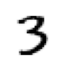

In [14]:
show_image(three_tensors[1]);

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a *rank-3 tensor*. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called `stack` that we can use for this purpose.

Some operations in PyTorch, such as taking a mean, require us to *cast* our integer types to float types. Since we'll be needing this later, we'll also cast our stacked tensor to `float` now. Casting in PyTorch is as simple as typing the name of the type you wish to cast to, and treating it as a method.

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:

对于每个像素位置，我们要计算该像素强度的所有图像的平均值。为了做到这一点，我们首先把这个列表中的所有图像合并成一个三维张量。描述这种张量最常见的方法是称它为*秩3 张量*。我们经常需要把集合中的单个张量叠加成一个张量。不出所料，PyTorch附带了一个名为`stack`的函数，我们可以使用它来实现这个目的。

PyTorch中的一些操作，例如取平均值，需要将整型*转换*为浮点型。由于我们之后会需要它，所以我们现在也要把叠加的张量转换为`float`。在 PyTorch 中进行转换非常简单，只需键入您希望转换为的类型的名称，然后将其作为一个方法来处理。

一般情况下，当图像是浮点数时，像素值应该在0到1之间，所以这里我们也将除以255：

In [15]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

Perhaps the most important attribute of a tensor is its *shape*. This tells you the length of each axis. In this case, we can see that we have 6,131 images, each of size 28×28 pixels. There is nothing specifically about this tensor that says that the first axis is the number of images, the second is the height, and the third is the width—the semantics of a tensor are entirely up to us, and how we construct it. As far as PyTorch is concerned, it is just a bunch of numbers in memory.

The *length* of a tensor's shape is its rank:

也许张量最重要的属性是它的*形状*。这告诉你每个轴的长度。在本例中，我们可以看到有6131张图片，每张图片的大小为28×28像素。关于这个张量，没有什么特别的东西表明第一个轴是图像的数量，第二个是高度，第三个是宽度——张量的语义完全取决于我们，以及我们如何构造它。就PyTorch而言，它只是内存中的一堆数字。

张量形状的*长度*就是它的秩:

In [16]:
len(stacked_threes.shape)

3

It is really important for you to commit to memory and practice these bits of tensor jargon: _rank_ is the number of axes or dimensions in a tensor; _shape_ is the size of each axis of a tensor.

> A: Watch out because the term "dimension" is sometimes used in two ways. Consider that we live in "three-dimensonal space" where a physical position can be described by a 3-vector `v`. But according to PyTorch, the attribute `v.ndim` (which sure looks like the "number of dimensions" of `v`) equals one, not three! Why? Because `v` is a vector, which is a tensor of rank one, meaning that it has only one _axis_ (even if that axis has a length of three). In other words, sometimes dimension is used for the size of an axis ("space is three-dimensional"); other times, it is used for the rank, or the number of axes ("a matrix has two dimensions"). When confused, I find it helpful to translate all statements into terms of rank, axis, and length, which are unambiguous terms.

对你们来说，记住并练习这些张量术语真的很重要：_秩_是张量中轴或维的数量； _形状_ 是张量每个轴的大小。

>A:要注意，因为“维度”这个词有时有两种用法。考虑到我们生活在“三维空间”中，物理位置可以用3-向量`v`来描述。但是根据PyTorch，属性`v.ndim`(看起来确实像`v`的“维数”)等于1，而不是3 !为什么?因为`v`是一个向量，它是一个秩为1的张量，这意味着它只有一个_轴_(即使该轴的长度是3)。换句话说，有时维度被用来表示轴的大小(“空间是三维的”)；其他时候，它是用于秩，或轴的数量(“一个矩阵有两个维度”)。当感到困惑时，我发现将所有的表述转换为秩、轴和长度是很有帮助的，这些都是明确的术语。

We can also get a tensor's rank directly with `ndim`:

我们也可以通过`ndim`直接得到一个张量的秩:

In [17]:
stacked_threes.ndim

3

Finally, we can compute what the ideal 3 looks like. We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.

In other words, for every pixel position, this will compute the average of that pixel over all images. The result will be one value for every pixel position, or a single image. Here it is:

最后，我们可以计算出理想 3 的样子。我们通过沿堆叠的 秩3 张量的 0 维取平均值来计算所有图像张量的平均值。这是索引所有图像的维度。

换句话说，对于每个像素位置，这将计算该像素在所有图像上的平均值。结果将是每个像素位置的一个值，或单个图像。这里是：

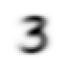

In [18]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

According to this dataset, this is the ideal number 3! (You may not like it, but this is what peak number 3 performance looks like.) You can see how it's very dark where all the images agree it should be dark, but it becomes wispy and blurry where the images disagree. 

Let's do the same thing for the 7s, but put all the steps together at once to save some time:

根据这个数据集，这是理想的数字3!(你可能不喜欢它，但这就是3号峰值性能的样子。)你可以看到，所有图像一致认为它应该是黑暗的地方，它是非常黑暗的，但在图像不一致的地方，它变得模糊不清。

让我们对7s做同样的事情，但将所有步骤放在一起以节省一些时间:

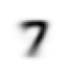

In [19]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Let's now pick an arbitrary 3 and measure its *distance* from our "ideal digits."

> stop: Stop and Think!: How would you calculate how similar a particular image is to each of our ideal digits? Remember to step away from this book and jot down some ideas before you move on! Research shows that recall and understanding improves dramatically when you are engaged with the learning process by solving problems, experimenting, and trying new ideas yourself

Here's a sample 3:

现在我们任意选一个3，然后测量它与“理想数字”的*距离*。

>停:停下来想想！:你如何计算特定的图像与我们每个理想数字的相似程度?在继续之前，记得离开这本书并记下一些想法！研究表明，当你通过自己解决问题、试验和尝试新想法来参与学习过程时，记忆力和理解力会显著提高

这是一个样本 3：

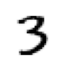

In [20]:
a_3 = stacked_threes[1]
show_image(a_3);

How can we determine its distance from our ideal 3? We can't just add up the differences between the pixels of this image and the ideal digit. Some differences will be positive while others will be negative, and these differences will cancel out, resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal. That would be misleading!

To avoid this, there are two main ways data scientists measure distance in this context:

- Take the mean of the *absolute value* of differences (absolute value is the function that replaces negative values with positive values). This is called the *mean absolute difference* or *L1 norm*
- Take the mean of the *square* of differences (which makes everything positive) and then take the *square root* (which undoes the squaring). This is called the *root mean squared error* (RMSE) or *L2 norm*.

> important: It's Okay to Have Forgotten Your Math: In this book we generally assume that you have completed high school math, and remember at least some of it... But everybody forgets some things! It all depends on what you happen to have had reason to practice in the meantime. Perhaps you have forgotten what a _square root_ is, or exactly how they work. No problem! Any time you come across a maths concept that is not explained fully in this book, don't just keep moving on; instead, stop and look it up. Make sure you understand the basic idea, how it works, and why we might be using it. One of the best places to refresh your understanding is Khan Academy. For instance, Khan Academy has a great [introduction to square roots](https://www.khanacademy.org/math/algebra/x2f8bb11595b61c86:rational-exponents-radicals/x2f8bb11595b61c86:radicals/v/understanding-square-roots).

我们如何确定它与理想3的距离?我们不能仅仅把这张图像的像素和理想数字之间的差异加起来。有些差异是正的，而有些是负的，这些差异会相互抵消，导致图像在某些地方太暗而在另一些地方太亮，可能会显示为与理想数字的总差异为零。那将是误导！


为了避免这种情况，数据科学家在这种情况下测量距离有两种主要方式：

- 取差值*绝对值*的平均值(绝对值是用正值代替负值的函数)。这叫做*平均绝对差*或*L1范数*
- 取差值*平方*的均值(使所有值都是正的)，然后取*平方根*(抵消平方)这叫做*均方根误差*(RMSE)或*L2范数*。

>重要：忘记你的数学也没关系：在这本书中，我们通常假设你已经完成了高中的数学课程，并且至少记住了一部分……但是每个人都会忘记一些事情！这完全取决于你碰巧在此期间有理由练习了什么。也许你已经忘记了什么是 _平方根_ ，或者它们到底是如何起作用的。没问题！每当你遇到本书未充分解释的数学概念时，不要只是继续看下去;相反，停下来查一查。确保你理解了它的基本思想，它是如何工作的，以及我们为什么要使用它。刷新您的理解的最佳场所之一是可汗学院。例如，可汗学院[对平方根有很好的介绍](https://www.khanacademy.org/math/algebra/x2f8bb11595b61c86:rational-exponents-radicals/x2f8bb11595b61c86:radicals/v/understanding-square-roots)。

Let's try both of these now:

现在让我们尝试这两种方法:

In [21]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [22]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. So our simple model will give the right prediction in this case.

在这两种情况下，3到“理想”3的距离都小于到理想7的距离。所以我们的简单模型会给出正确的预测。

PyTorch already provides both of these as *loss functions*. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as `F` (and is available by default under that name in fastai):

PyTorch已经将这两个函数作为*损失函数*提供。你可以在`torch.nn.functional`中找到这些。PyTorch团队建议将其导入为`F` (并且在fastai中默认使用该名称):


In [23]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

Here `mse` stands for *mean squared error*, and `l1` refers to the standard mathematical jargon for *mean absolute value* (in math it's called the *L1 norm*).

这里`mse`代表*均方误差*，`l1`指的是*平均绝对值*的标准数学术语(在数学中称为*L1范数*)。

> S: Intuitively, the difference between L1 norm and mean squared error (MSE) is that the latter will penalize bigger mistakes more heavily than the former (and be more lenient with small mistakes).

>S:直观上，L1范数和均方误差(MSE) 的区别在于后者会比前者更严厉地惩罚更大的错误（并且对小错误更宽容）。

> J: When I first came across this "L1" thingie, I looked it up to see what on earth it meant. I found on Google that it is a _vector norm_ using _absolute value_, so looked up _vector norm_ and started reading: _Given a vector space V over a field F of the real or complex numbers, a norm on V is a nonnegative-valued any function p: V → \[0,+∞) with the following properties: For all a ∈ F and all u, v ∈ V, p(u + v) ≤ p(u) + p(v)..._ Then I stopped reading. "Ugh, I'll never understand math!" I thought, for the thousandth time. Since then I've learned that every time these complex mathy bits of jargon come up in practice, it turns out I can replace them with a tiny bit of code! Like, the _L1 loss_ is just equal to `(a-b).abs().mean()`, where `a` and `b` are tensors. I guess mathy folks just think differently than me... I'll make sure in this book that every time some mathy jargon comes up, I'll give you the little bit of code it's equal to as well, and explain in common-sense terms what's going on.

>J:当我第一次看到“L1”这个词的时候，我就查了一下，想知道它到底是什么意思。我在谷歌上发现它是一个使用_绝对值_的_向量范数_ ，所以查找_向量范数_ 并开始阅读: _给定一个实数或复数域F上的向量空间V, V上的范数是一个非负值的任意函数p: V→[0，+∞），具有以下性质：对于所有a∈F和所有u, v∈V, p(u + v)≤p(u) + p(v)..._ 然后我就不读了。我无数次地想“啊，我永远都不懂数学了!”。从那以后，我学会了每次在实践中出现这些复杂的数学术语时，我都可以用一小段代码来替换它们！比如， _L1损失_ 就等于`(a-b).abs().mean()`，其中`a`和`b`是张量。我想数学家的想法和我的不一样…我会确保在这本书中，每次出现一些数学术语，我会给出它等于的代码，然后用常识性的术语解释发生了什么。


We just completed various mathematical operations on PyTorch tensors. If you've done some numeric programming in NumPy before, you may recognize these as being similar to NumPy arrays. Let's have a look at those two very important data structures.

我们刚刚完成了对PyTorch张量的各种数学运算。如果您以前使用NumPy进行过一些数值编程，那么您可能会认为这些类似于NumPy数组。让我们来看看这两个非常重要的数据结构。

### NumPy Arrays and PyTorch Tensors

### NumPy数组和PyTorch张量

[NumPy](https://numpy.org/) is the most widely used library for scientific and numeric programming in Python. It provides very similar functionality and a very similar API to that provided by PyTorch; however, it does not support using the GPU or calculating gradients, which are both critical for deep learning. Therefore, in this book we will generally use PyTorch tensors instead of NumPy arrays, where possible.

(Note that fastai adds some features to NumPy and PyTorch to make them a bit more similar to each other. If any code in this book doesn't work on your computer, it's possible that you forgot to include a line like this at the start of your notebook: `from fastai.vision.all import *`.)

But what are arrays and tensors, and why should you care?

[NumPy](https://numpy.org/)是Python 中使用最广泛的科学和数值编程库。它提供了与PyTorch非常相似的功能和API；但是，它不支持使用GPU或计算梯度，这两个都是深度学习的关键。因此，在本书中，我们通常会尽可能地使用PyTorch张量而不是NumPy数组。

(注意fastai为NumPy和PyTorch添加了一些功能，使它们彼此更加相似。如果这本书中的任何代码在你的电脑上不起作用，你可能忘记在你的笔记本的开头包括这样的一行:`from fastai.vision.all import *`。)

但是什么是数组和张量，为什么要关心这些呢?

Python is slow compared to many languages. Anything fast in Python, NumPy, or PyTorch is likely to be a wrapper for a compiled object written (and optimized) in another language—specifically C. In fact, **NumPy arrays and PyTorch tensors can finish computations many thousands of times faster than using pure Python.**

A NumPy array is a multidimensional table of data, with all items of the same type. Since that can be any type at all, they can even be arrays of arrays, with the innermost arrays potentially being different sizes—this is called a "jagged array." By "multidimensional table" we mean, for instance, a list (dimension of one), a table or matrix (dimension of two), a "table of tables" or "cube" (dimension of three), and so forth. If the items are all of some simple type such as integer or float, then NumPy will store them as a compact C data structure in memory. This is where NumPy shines. NumPy has a wide variety of operators and methods that can run computations on these compact structures at the same speed as optimized C, because they are written in optimized C.

A PyTorch tensor is nearly the same thing as a NumPy array, but with an additional restriction that unlocks some additional capabilities. It's the same in that it, too, is a multidimensional table of data, with all items of the same type. However, the restriction is that a tensor cannot use just any old type—it has to use a single basic numeric type for all components. For example, a PyTorch tensor cannot be jagged. It is always a regularly shaped multidimensional rectangular structure.

The vast majority of methods and operators supported by NumPy on these structures are also supported by PyTorch, but PyTorch tensors have additional capabilities. One major capability is that these structures can live on the GPU, in which case their computation will be optimized for the GPU and can run much faster (given lots of values to work on). In addition, PyTorch can automatically calculate derivatives of these operations, including combinations of operations. As you'll see, it would be impossible to do deep learning in practice without this capability.

> S: If you don't know what C is, don't worry as you won't need it at all. In a nutshell, it's a low-level  (low-level means more similar to the language that computers use internally) language that is very fast compared to Python. To take advantage of its speed while programming in Python, try to avoid as much as possible writing loops, and replace them by commands that work directly on arrays or tensors.

Perhaps the most important new coding skill for a Python programmer to learn is how to effectively use the array/tensor APIs. We will be showing lots more tricks later in this book, but here's a summary of the key things you need to know for now.

与许多语言相比，Python是缓慢的。Python、NumPy或PyTorch中任何快速的东西都可能是用另一种语言(特别是c)编写(并优化)的编译对象的包装器。事实上，**NumPy数组和PyTorch张量完成计算的速度比使用纯Python快数千倍**。

NumPy数组是一个多维数据表，所有项都是相同类型的。因为它可以是任何类型，它们甚至可以是数组的数组，最里面的数组可能有不同的大小——这被称为“锯齿状数组”。例如，一个列表（一维）、一个表或矩阵（二维）、一个“表的表”或“立方体”（三维）等等。如果项目都是一些简单类型，比如整型或浮点型，那么NumPy将它们作为紧凑的C数据结构存储在内存中。这就是NumPy大放异彩的地方。NumPy有各种各样的运算符和方法，可以以与优化的 C 相同的速度在这些紧凑结构上运行计算，因为它们是用优化的C编写的。

PyTorch张量几乎与NumPy数组相同，但有一个额外的限制，可以解锁一些额外的功能。它的相同之处在于，它也是一个多维数据表，所有项都是相同类型的。然而，限制是张量不能仅仅使用任何旧类型——它必须对所有分量使用单一的基本数字类型。例如，PyTorch张量不能是锯齿状的。它总是一个规则形状的多维矩形结构。

PyTorch也支持NumPy在这些结构上支持的绝大多数方法和操作符，但PyTorch 张量具有额外的功能。一个主要的功能是这些结构可以在GPU上运行，在这种情况下，它们的计算针对 GPU 进行优化，并且可以运行得更快（给定大量的工作值）。此外，PyTorch可以自动计算这些操作的导数，包括操作的组合。正如你将看到的，在实践中，如果没有这种能力，就不可能在实践中进行深度学习。

>S:如果你不知道C是什么，别担心，因为你根本不需要它。简而言之，它是一种低级(低级意味着更类似于计算机内部使用的语言)语言，与Python相比速度非常快。为了在使用 Python 编程时利用它的速度，请尽量避免编写循环，并用直接在数组或张量上工作的命令替换它们。

对于Python程序员来说，最重要的新编码技能可能是如何有效地使用数组/张量 API。我们将在本书后面展示更多的技巧，但这里是你现在需要知道的关键事情的总结。

To create an array or tensor, pass a list (or list of lists, or list of lists of lists, etc.) to `array()` or `tensor()`:

要创建数组或张量，请将列表(或列表的列表，或列表的列表的列表等)传递给`array()`或`tensor()`:

In [24]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [25]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [26]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

All the operations that follow are shown on tensors, but the syntax and results for NumPy arrays is identical.

You can select a row (note that, like lists in Python, tensors are 0-indexed so 1 refers to the second row/column):

接下来的所有操作都显示在张量上，但NumPy数组的语法和结果是相同的。

你可以选择一行(注意，与Python中的列表一样，张量是0索引的，所以1指的是第二行/列):

In [27]:
tns[1]

tensor([4, 5, 6])

or a column, by using `:` to indicate *all of the first axis* (we sometimes refer to the dimensions of tensors/arrays as *axes*):

或者一列，用`:`表示*所有第一个轴*(我们有时把张量/数组的维度称为*轴*):

In [28]:
tns[:,1]

tensor([2, 5])

You can combine these with Python slice syntax (`[start:end]` with `end` being excluded) to select part of a row or column:

你可以将这些与Python切片语法(`[start:end]`， `end`被排除)相结合来选择行或列的一部分:

In [29]:
tns[1,1:3]

tensor([5, 6])

And you can use the standard operators such as `+`, `-`, `*`, `/`:

你可以使用标准运算符，如`+`，`-`，`*`，`/`:

In [30]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

Tensors have a type:

张量有一种类型:

In [31]:
tns.type()

'torch.LongTensor'

And will automatically change type as needed, for example from `int` to `float`:

并且会根据需要自动更改类型，例如从`int`到`float`:

In [32]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

So, is our baseline model any good? To quantify this, we must define a metric.

那么，我们的基线模型好吗?为了量化这一点，我们必须定义一个指标。

## Computing Metrics Using Broadcasting

## 使用广播计算指标

Recall that a metric is a number that is calculated based on the predictions of our model, and the correct labels in our dataset, in order to tell us how good our model is. For instance, we could use either of the functions we saw in the previous section, mean squared error, or mean absolute error, and take the average of them over the whole dataset. However, neither of these are numbers that are very understandable to most people; in practice, we normally use *accuracy* as the metric for classification models.

As we've discussed, we want to calculate our metric over a *validation set*. This is so that we don't inadvertently overfit—that is, train a model to work well only on our training data. This is not really a risk with the pixel similarity model we're using here as a first try, since it has no trained components, but we'll use a validation set anyway to follow normal practices and to be ready for our second try later.

To get a validation set we need to remove some of the data from training entirely, so it is not seen by the model at all. As it turns out, the creators of the MNIST dataset have already done this for us. Do you remember how there was a whole separate directory called *valid*? That's what this directory is for!

So to start with, let's create tensors for our 3s and 7s from that directory. These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image:

回想一下，指标是根据我们的模型的预测和数据集中的正确标签计算得出的数字，以告诉我们我们的模型有多好。例如，我们可以使用我们在上一节中看到的任何一个函数，均方误差或平均绝对误差，并在整个数据集中取它们的平均值。然而，这两个数字对大多数人来说都不是很容易理解的;在实践中，我们通常使用*准确率*作为分类模型的指标。

正如我们所讨论的，我们希望在*验证集*上计算我们的指标。这样我们就不会无意中过度拟合——也就是说，训练一个模型只在我们的训练数据上运行良好。对于我们在这里作为第一次尝试使用的像素相似度模型来说，这并不是真正的风险，因为它没有经过训练的组件，但无论如何我们都会使用验证集来遵循正常的做法，并为以后的第二次尝试做好准备。

要获得验证集，我们需要从训练中完全删除一些数据，因此模型根本看不到它。事实证明，MNIST数据集的创建者已经为我们完成了这件事。您还记得如何有一个完整的单独目录称为*valid*吗？这就是这个目录的用途！

所以首先，让我们从该目录为我们的3s和7s创建张量。这些张量将用于计算衡量我们的第一次尝试模型质量的指标，该模型测量与理想图像的距离：

In [33]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

It's good to get in the habit of checking shapes as you go. Here we see two tensors, one representing the 3s validation set of 1,010 images of size 28×28, and one representing the 7s validation set of 1,028 images of size 28×28.

We ultimately want to write a function, `is_3`, that will decide if an arbitrary image is a 3 or a 7. It will do this by deciding which of our two "ideal digits" this arbitrary image is closer to. For that we need to define a notion of distance—that is, a function that calculates the distance between two images.

We can write a simple function that calculates the mean absolute error using an expression very similar to the one we wrote in the last section:

养成检查形状的习惯是很好的。这里我们看到两个张量，一个代表 1,010 张 28×28 图像的 3s 验证集，一个代表 1,028 张 28×28 图像的 7s 验证集。

我们最终想写一个函数，`is_3`，来决定任意图像是3还是7。它将通过确定任意图像与两个“理想数字”中的哪一个更接近来实现这一点。为此，我们需要定义一个距离的概念——即计算两幅图像之间距离的函数。

我们可以编写一个简单的函数，使用与我们在上一节中编写的表达式非常相似的表达式来计算平均绝对误差:

In [34]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

This is the same value we previously calculated for the distance between these two images, the ideal 3 `mean3` and the arbitrary sample 3 `a_3`, which are both single-image tensors with a shape of `[28,28]`.

But in order to calculate a metric for overall accuracy, we will need to calculate the distance to the ideal 3 for _every_ image in the validation set. How do we do that calculation? We could write a loop over all of the single-image tensors that are stacked within our validation set tensor, `valid_3_tens`, which has a shape of `[1010,28,28]` representing 1,010 images. But there is a better way.

Something very interesting happens when we take this exact same distance function, designed for comparing two single images, but pass in as an argument `valid_3_tens`, the tensor that represents the 3s validation set:

这与我们之前为这两个图像之间的距离计算的值相同，理想的3`mean3`和任意的样本3`a_3`，它们都是形状为`[28,28]`的单图像张量。

但是为了计算整体准确度的指标，我们需要计算验证集中 _每个_ 图像到理想3的距离。我们怎么计算呢?我们可以对堆叠在我们的验证集张量中的所有单张图像张量编写一个循环`valid_3_tens`，它的形状`[1010,28,28]`，表示1010张图像。但是有一个更好的方法。

当我们使用这个完全相同的距离函数时，会发生非常有趣的事情，这个距离函数是为比较两个单张图像而设计的，但作为参数传入`valid_3_tens`，表示 3s 验证集的张量：

In [35]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]),
 torch.Size([1010]))

Instead of complaining about shapes not matching, it returned the distance for every single image as a vector (i.e., a rank-1 tensor) of length 1,010 (the number of 3s in our validation set). How did that happen?

Take another look at our function `mnist_distance`, and you'll see we have there the subtraction `(a-b)`. The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use *broadcasting*. That is, it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. Broadcasting is an important capability that makes tensor code much easier to write.

After broadcasting so the two argument tensors have the same rank, PyTorch applies its usual logic for two tensors of the same rank: it performs the operation on each corresponding element of the two tensors, and returns the tensor result. For instance:

它没有抱怨形状不匹配，而是将每幅图像的距离作为长度为1010(验证集中3的个数)的向量(即秩1张量)返回。这是怎么发生的?

再看一下我们的函数`mnist_distance`，你会发现我们有减法`(a-b)`。PyTorch的神奇之处在于，当它试图在两个不同秩的张量之间执行一个简单的减法运算时，将使用*广播*。也就是说，它会自动扩展秩较小的张量，使其与秩较大的张量具有相同的大小。广播是一种重要的能力，它使张量代码更容易编写。

广播后，两个参数张量具有相同的秩，PyTorch 将其通常的逻辑应用于相同秩的两个张量：它对两个张量的每个对应元素执行操作，并返回张量结果。例如：

In [36]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

So in this case, PyTorch treats `mean3`, a rank-2 tensor representing a single image, as if it were 1,010 copies of the same image, and then subtracts each of those copies from each 3 in our validation set. What shape would you expect this tensor to have? Try to figure it out yourself before you look at the answer below:

因此，在这种情况下，PyTorch 将`mean3`表示单个图像的 秩2 张量视为同一图像的 1,010 个副本，然后用验证集中的每个3减去这些副本。你希望这个张量有什么形状?在查看以下答案之前，请尝试自己弄清楚：

In [37]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

We are calculating the difference between our "ideal 3" and each of the 1,010 3s in the validation set, for each of 28×28 images, resulting in the shape `[1010,28,28]`.

There are a couple of important points about how broadcasting is implemented, which make it valuable not just for expressivity but also for performance:

- PyTorch doesn't *actually* copy `mean3` 1,010 times. It *pretends* it were a tensor of that shape, but doesn't actually allocate any additional memory
- It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).

This is true of all broadcasting and elementwise operations and functions done in PyTorch. *It's the most important technique for you to know to create efficient PyTorch code.*

Next in `mnist_distance` we see `abs`. You might be able to guess now what this does when applied to a tensor. It applies the method to each individual element in the tensor, and returns a tensor of the results (that is, it applies the method "elementwise"). So in this case, we'll get back 1,010 matrices of absolute values.

Finally, our function calls `mean((-1,-2))`. The tuple `(-1,-2)` represents a range of axes. In Python, `-1` refers to the last element, and `-2` refers to the second-to-last. So in this case, this tells PyTorch that we want to take the mean ranging over the values indexed by the last two axes of the tensor. The last two axes are the horizontal and vertical dimensions of an image. After taking the mean over the last two axes, we are left with just the first tensor axis, which indexes over our images, which is why our final size was `(1010)`. In other words, for every image, we averaged the intensity of all the pixels in that image.

We'll be learning lots more about broadcasting throughout this book, especially in <<chapter_foundations>>, and will be practicing it regularly too.

We can use `mnist_distance` to figure out whether an image is a 3 or not by using the following logic: if the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it's a 3. This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators:

我们正在计算我们的“理想3”和验证集中的1,010个3之间的差异，对于每个28×28图片，得到的形状为`[1010,28,28]`。

关于广播是如何实现的，有几个要点，这使得它不仅在表现力上有价值，而且在性能上也有价值：

- PyTorch*实际上*并没有复制`mean3` 1,010次。它*假装*它是那种形状的张量，但实际上并不分配任何额外的内存
- 它以C（或者，如果您使用的是GPU，则在CUDA中，相当于GPU上的C）完成整个计算，比纯Python快数万倍(在GPU上快数百万倍!)

在 PyTorch 中完成的所有广播和元素操作和函数都是如此。*这是创建高效 PyTorch 代码的最重要技术。*

接下来在`mnist_distance`中我们看到了`abs`。现在你可能已经猜到当它应用于一个张量时会发生什么。它将该方法应用于张量中的每个单独元素，并返回结果的张量(即，它“按元素”应用方法)。所以在这种情况下，我们将得到 1,010 个绝对值矩阵。

最后，我们的函数调用`mean((-1，-2))`。元组`(-1，-2)`表示轴的范围。在Python中，`-1`表示最后一个元素，`-2`表示倒数第二个元素。所以在这种情况下，这告诉PyTorch我们希望在张量的最后两个轴索引的值上取平均值范围。最后两个轴是图像的水平和垂直维度。在对最后两个轴取平均值后，我们只剩下第一个张量轴，它对我们的图像进行索引，这就是为什么我们的最终大小是`（1010）`。换句话说，对于每张图像，我们平均了该图像中所有像素的强度。

通过这本书，我们将学到更多关于广播的知识，尤其是在<<chapter_foundations>>中，我们还会定期练习。

我们可以使用`mnist_distance`通过以下逻辑来判断一张图像是否为3:如果所讨论数字和理想3之间的距离小于与理想7之间的距离，那么它就是3。此函数将自动进行广播并按元素应用，就像所有PyTorch函数和运算符一样:

In [38]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

Let's test it on our example case:

让我们在我们的示例案例中测试它：

In [39]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

Note that when we convert the Boolean response to a float, we get `1.0` for `True` and `0.0` for `False`. Thanks to broadcasting, we can also test it on the full validation set of 3s:

请注意，当我们将布尔响应转换为浮点数时，`True`为`1.0`，`False`为`0.0`。得益于广播，我们还可以在3s的完整验证集上测试它：

In [40]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

Now we can calculate the accuracy for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s:

现在我们可以通过对所有 3 取该函数的平均值及对所有 7 取反的函数的平均值来计算每个 3 和 7 的准确度：

In [ ]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

This looks like a pretty good start! We're getting over 90% accuracy on both 3s and 7s, and we've seen how to define a metric conveniently using broadcasting.

But let's be honest: 3s and 7s are very different-looking digits. And we're only classifying 2 out of the 10 possible digits so far. So we're going to need to do better!

To do better, perhaps it is time to try a system that does some real learning—that is, that can automatically modify itself to improve its performance. In other words, it's time to talk about the training process, and SGD.

这看起来是个不错的开始!我们在3s和7s上的准确率都超过了90%，并且我们已经了解了如何使用广播方便地定义指标。

但说实话:3s和7s看起来是完全不同的数字。到目前为止，我们只对 10 个可能的数字中的 2 个进行分类。所以我们需要做得更好！

为了做得更好，也许是时候尝试一个能够进行一些真正学习的系统了——也就是说，它可以自动修改自身以提高其性能。换句话说，是时候谈谈训练过程和SGD了。

## Stochastic Gradient Descent (SGD)

## 随机梯度下降(SGD)

Do you remember the way that Arthur Samuel described machine learning, which we quoted in <<chapter_intro>>?

> : Suppose we arrange for some automatic means of testing the effectiveness of any current weight assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximize the performance. We need not go into the details of such a procedure to see that it could be made entirely automatic and to see that a machine so programmed would "learn" from its experience.

As we discussed, this is the key to allowing us to have a model that can get better and better—that can learn. But our pixel similarity approach does not really do this. We do not have any kind of weight assignment, or any way of improving based on testing the effectiveness of a weight assignment. In other words, we can't really improve our pixel similarity approach by modifying a set of parameters. In order to take advantage of the power of deep learning, we will first have to represent our task in the way that Arthur Samuel described it.

Instead of trying to find the similarity between an image and an "ideal image," we could instead look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category. For instance, pixels toward the bottom right are not very likely to be activated for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. This can be represented as a function and set of weight values for each possible category—for instance the probability of being the number 8:

```
def pr_eight(x,w): return (x*w).sum()
```

你还记得我们在<<chapter_intro>>中引用的Arthur Samuel描述机器学习的方式吗?

>:假设我们安排一些自动方法来测试任何当前权重分配在实际性能方面的有效性，并提供一种改变权重分配的机制以最大化性能。我们不需要深入了解这样一个程序的细节，就可以看到它可以完全自动化，并看到这样编程的机器会从它的经验中“学习”。

正如我们所讨论的，这是让我们拥有一个可以变得越来越好——可以学习的模型的关键。但是我们的像素相似度方法并不能真正做到这一点。我们没有任何类型的权重分配，也没有任何基于测试权重分配有效性的改进方式。换句话说，我们不能通过修改一组参数来真正改进我们的像素相似度方法。为了充分利用深度学习的力量，我们首先必须按照Arthur Samuel描述的方式来表示我们的任务。

与其试图找到图像和“理想图像”之间的相似性，我们可以查看每个单独的像素并为每个像素提出一组权重，这样，最高的权重就与那些在特定类别中最有可能是黑色的像素相关联。例如，右下角的像素对于7不太可能被激活，所以它们对于7应该具有较低的权重，但对于8却可能被激活，所以它们对于8应该具有较高的权重。这可以表示为每个可能类别的函数和一组权重值——例如，成为数字8的概率:

```
def pr_eight(x,w): return (x*w).sum()
```

Here we are assuming that `x` is the image, represented as a vector—in other words, with all of the rows stacked up end to end into a single long line. And we are assuming that the weights are a vector `w`. If we have this function, then we just need some way to update the weights to make them a little bit better. With such an approach, we can repeat that step a number of times, making the weights better and better, until they are as good as we can make them.

We want to find the specific values for the vector `w` that causes the result of our function to be high for those images that are actually 8s, and low for those images that are not. Searching for the best vector `w` is a way to search for the best function for recognising 8s. (Because we are not yet using a deep neural network, we are limited by what our function can actually do—we are going to fix that constraint later in this chapter.) 

To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

这里我们假设`x`是图像，用一个向量表示——换句话说，所有的行首尾相连地堆叠成一条长线。我们假设权重是一个向量`w`，如果我们有这个函数，那么我们只需要一些方法来更新权重让它们变得更好。通过这种方法，我们可以多次重复该步骤，使权重越来越好，直到它们达到我们所能达到的最好水平。

我们想找出向量`w`的具体值，使函数的结果对于那些实际上是8s的图像是高的，对于那些不是8s的图像是低的。寻找最佳向量`w`是搜索识别8的最佳函数的一种方法。(因为我们还没有使用深度神经网络，所以我们受限于我们的函数实际上可以做什么——我们将在本章后面解决这个限制。)

更具体地说，以下是我们将需要的步骤，将这个函数变成机器学习分类器:

1. *初始化*权重。
1. 对于每一张图片，使用这些权重来*预测*它看起来是3还是7。
1. 根据这些预测，计算模型的好坏(它的*损失*)。
1. 计算*梯度*，测量每个权重，改变权重将如何改变损失
1. 根据该计算*逐步*（即更改）所有权重。
1. 回到第2步，*重复*这个过程。
1. 迭代，直到您决定*停止*训练过程(例如，因为模型已经足够好，或者您不想再等了)。

These seven steps, illustrated in <<gradient_descent>>, are the key to the training of all deep learning models. That deep learning turns out to rely entirely on these steps is extremely surprising and counterintuitive. It's amazing that this process can solve such complex problems. But, as you'll see, it really does!

这七个步骤，如<<gradient_descent>>所示，是所有深度学习模型训练的关键。事实证明，深度学习完全依赖于这些步骤，这是非常令人惊讶和违反直觉的。令人惊讶的是，这个过程可以解决如此复杂的问题。但是，正如您将看到的，它确实如此!

In [ ]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

There are many different ways to do each of these seven steps, and we will be learning about them throughout the rest of this book. These are the details that make a big difference for deep learning practitioners, but it turns out that the general approach to each one generally follows some basic principles. Here are a few guidelines:

- Initialize:: We initialize the parameters to random values. This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well.
- Loss:: This is what Samuel referred to when he spoke of *testing the effectiveness of any current weight assignment in terms of actual performance*. We need some function that will return a number that is small if the performance of the model is good (the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention).
- Step:: A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating *gradients*. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.
- Stop:: Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision. This is where that decision is applied. For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.

这七个步骤中的每一个都有许多不同的方法，我们将在本书的其余部分学习它们。这些细节对深度学习从业者来说意义重大，但事实证明，处理每个细节的一般方法通常遵循一些基本原则。以下是一些指导方针:

- Initialize::我们将参数初始化为随机值。这听起来可能令人惊讶。我们当然可以做出其他选择，例如将它们初始化为该类别的像素被激活的百分比——但是因为我们已经知道我们有一个提高这些权重的例程，事实证明，从随机权重开始工作非常好。
- Loss::这就是塞缪尔在谈到*根据实际性能测试当前权重分配的有效性*时所指的。我们需要一些函数，如果模型的性能好，它会返回一个小数字（标准方法是将小损失视为好，将大损失视为坏，尽管这只是一个惯例）。
- Step::计算权重是应该增加一点还是减少一点的一个简单方法就是尝试一下:将权重增加一小部分，看看损失是增加还是减少。一旦你找到正确的方向，你可以将这个量再增加一点，或者减少一点，直到你找到一个很好的量。然而，这很慢！正如我们将看到的，微积分的神奇之处让我们可以直接计算出每个权值的变化方向，以及大概变化多少，而不需要尝试所有这些小的变化。做到这一点的方法是计算*梯度*。这只是一个性能优化，通过使用较慢的手动过程，我们也会得到完全相同的结果。
- Stop::一旦我们决定了训练模型的 epoch 数(在前面的列表中给出了一些建议)，我们就应用这个决定。这就是应用该决定的地方。对于我们的数字分类器，我们会一直训练，直到模型的准确性开始变差，或者我们的时间用完了。

Before applying these steps to our image classification problem, let's illustrate what they look like in a simpler case. First we will define a very simple function, the quadratic—let's pretend that this is our loss function, and `x` is a weight parameter of the function:

在将这些步骤应用到我们的图像分类问题之前，让我们用一个更简单的例子来说明它们的样子。首先我们将定义一个非常简单的函数，即二次函数——假设这是我们的损失函数，并且`x`是函数的权重参数:

In [43]:
def f(x): return x**2

Here is a graph of that function:

这是该函数的图:

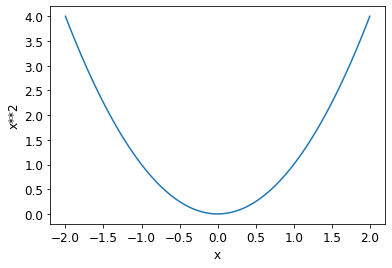

In [44]:
plot_function(f, 'x', 'x**2')

The sequence of steps we described earlier starts by picking some random value for a parameter, and calculating the value of the loss:

我们前面描述的步骤序列首先为参数选择一些随机值，并计算损失值:

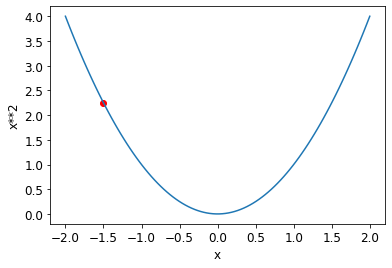

In [45]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

Now we look to see what would happen if we increased or decreased our parameter by a little bit—the *adjustment*. This is simply the slope at a particular point:

现在我们看看如果我们稍微增加或减少参数会发生什么——*调整*。这仅仅是某一点的斜率:

<img alt="A graph showing the squared function with the slope at one point" width="400" src="https://github.com/fastai/fastbook/blob/master/images/grad_illustration.svg?raw=1"/>

We can change our weight by a little in the direction of the slope, calculate our loss and adjustment again, and repeat this a few times. Eventually, we will get to the lowest point on our curve:

我们可以在斜率方向稍微改变我们的权重，再次计算我们的损失和调整，并重复几次。最终，我们将到达曲线上的最低点:

<img alt="An illustration of gradient descent" width="400" src="https://github.com/fastai/fastbook/blob/master/images/chapter2_perfect.svg?raw=1"/>

This basic idea goes all the way back to Isaac Newton, who pointed out that we can optimize arbitrary functions in this way. Regardless of how complicated our functions become, this basic approach of gradient descent will not significantly change. The only minor changes we will see later in this book are some handy ways we can make it faster, by finding better steps.

这个基本的思想可以追溯到艾萨克·牛顿，他指出我们可以用这种方法优化任意函数。无论我们的函数变得多么复杂，梯度下降的基本方法都不会有明显的变化。我们将在本书后面看到的唯一微小变化是一些方便的方法，可以通过找到更好的步骤来使其更快。

### Calculating Gradients



### 计算梯度

The one magic step is the bit where we calculate the gradients. As we mentioned, we use calculus as a performance optimization; it allows us to more quickly calculate whether our loss will go up or down when we adjust our parameters up or down. In other words, the gradients will tell us how much we have to change each weight to make our model better.

You may remember from your high school calculus class that the *derivative* of a function tells you how much a change in its parameters will change its result. If not, don't worry, lots of us forget calculus once high school is behind us! But you will have to have some intuitive understanding of what a derivative is before you continue, so if this is all very fuzzy in your head, head over to Khan Academy and complete the [lessons on basic derivatives](https://www.khanacademy.org/math/differential-calculus/dc-diff-intro). You won't have to know how to calculate them yourselves, you just have to know what a derivative is.

The key point about a derivative is this: for any function, such as the quadratic function we saw in the previous section, we can calculate its derivative. The derivative is another function. It calculates the change, rather than the value. For instance, the derivative of the quadratic function at the value 3 tells us how rapidly the function changes at the value 3. More specifically, you may recall that gradient is defined as *rise/run*, that is, the change in the value of the function, divided by the change in the value of the parameter. When we know how our function will change, then we know what we need to do to make it smaller. This is the key to machine learning: having a way to change the parameters of a function to make it smaller. Calculus provides us with a computational shortcut, the derivative, which lets us directly calculate the gradients of our functions.

一个神奇的步骤是我们计算梯度的部分。正如我们提到的，我们使用微积分来进行性能优化；当我们向上或向下调整参数时，它可以让我们更快地计算出我们的损失是增加还是减少。换句话说，梯度将告诉我们，为了使模型更好，我们必须对每个权重改变多少。

你可能还记得高中的微积分课上说过，一个函数的*导数*告诉你它的参数的变化会对结果产生多大的影响。如果没有，不要担心，很多人高中毕业后就会忘记微积分！但在你继续之前，你必须对导数有一些直观的理解，所以如果这些在你的脑海中都很模糊，去可汗学院完成[基本导数的课程](https://www.khanacademy.org/math/differential-calculus/dc-diff-intro)。你们不需要知道如何计算它们，你们只需要知道导数是什么。

关于导数的关键点是:对于任何函数，比如我们在上一节看到的二次函数，我们都可以计算它的导数。导数是另一个函数。它计算的是变化，而不是值。例如，二次函数在值为3处的导数告诉我们函数在值为3处的变化的速度。更具体地说，你可能还记得梯度被定义为*上升/运行*，即函数值的变化除以参数值的变化。当我们知道函数会如何变化时，我们就知道我们需要做些什么来使它变小。这是机器学习的关键:有一种方法可以改变函数的参数，使其更小。微积分为我们提供了一种计算捷径，即导数，它可以让我们直接计算函数的梯度。

One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative we won't get back one number, but lots of them—a gradient for every weight. But there is nothing mathematically tricky here; you can calculate the derivative with respect to one weight, and treat all the other ones as constant, then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.

We mentioned just now that you won't have to calculate any gradients yourself. How can that be? Amazingly enough, PyTorch is able to automatically compute the derivative of nearly any function! What's more, it does it very fast. Most of the time, it will be at least as fast as any derivative function that you can create by hand. Let's see an example.

First, let's pick a tensor value which we want gradients at:

需要注意的重要一点是，我们的函数有很多权重需要调整，所以当我们计算导数时，我们不会得到一个数字，而是很多——每个权重的梯度。但这里没有什么数学上的难题；你可以计算一个权重的导数，并将所有其他权重视为常数，然后对其他权重重复此操作。这是计算每个权重的所有梯度的方式。

我们刚才提到，你不需要自己计算任何梯度。这怎么可能呢?令人惊讶的是，PyTorch能够自动计算几乎任何函数的导数！更重要的是，它做得非常快。大多数情况下，它至少与您可以手动创建的任何导数函数一样快。我们来看一个例子。

首先，让我们选择一个我们想要梯度的张量值：

In [46]:
xt = tensor(3.).requires_grad_()

Notice the special method `requires_grad_`? That's the magical incantation we use to tell PyTorch that we want to calculate gradients with respect to that variable at that value. It is essentially tagging the variable, so PyTorch will remember to keep track of how to compute gradients of the other, direct calculations on it that you will ask for.

> a: This API might throw you off if you're coming from math or physics. In those contexts the "gradient" of a function is just another function (i.e., its derivative), so you might expect gradient-related APIs to give you a new function. But in deep learning, "gradients" usually means the _value_ of a function's derivative at a particular argument value. The PyTorch API also puts the focus on the argument, not the function you're actually computing the gradients of. It may feel backwards at first, but it's just a different perspective.

Now we calculate our function with that value. Notice how PyTorch prints not just the value calculated, but also a note that it has a gradient function it'll be using to calculate our gradients when needed:

注意特殊方法`requires_grad_`?这就是我们用来告诉PyTorch我们想要计算该变量在该值处的梯度的神奇方法。它本质上是标记变量，所以PyTorch会记得跟踪如何计算其他变量的梯度，直接计算你将要求的梯度。

>a:如果你是数学或物理出身，这个API可能会让你困惑。在这些情况下，函数的“梯度”只是另一个函数(即它的导数)，所以您可能希望与梯度相关的API提供给您一个新函数。但在深度学习中，“梯度”通常意味着函数在特定参数值处的导数 _值_ 。PyTorch API也将重点放在参数上，而不是实际计算梯度的函数上。一开始可能会觉得有点落后，但这只是一个不同的视角。

现在我们使用该值计算我们的函数。请注意PyTorch不仅打印计算的值，还打印了一个注释，说明它有一个梯度函数，它将在需要时用于计算我们的梯度：

In [47]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

Finally, we tell PyTorch to calculate the gradients for us:

最后，我们告诉PyTorch为我们计算梯度:

In [48]:
yt.backward()

The "backward" here refers to *backpropagation*, which is the name given to the process of calculating the derivative of each layer. We'll see how this is done exactly in chapter <<chapter_foundations>>, when we calculate the gradients of a deep neural net from scratch. This is called the "backward pass" of the network, as opposed to the "forward pass," which is where the activations are calculated. Life would probably be easier if `backward` was just called `calculate_grad`, but deep learning folks really do like to add jargon everywhere they can!

这里的“向后”指的是*反向传播*，即计算每一层导数的过程。当我们从头开始计算深度神经网络的梯度时，我们将在<<chapter_foundations>>章中看到这是如何准确地完成的，这被称为网络的“向后传递”，而不是“向前传递”，后者是计算激活的地方。如果`backward`只被称为`calculate_grad`，可能更容易理解，但深度学习的人真的喜欢在任何地方添加术语！

We can now view the gradients by checking the `grad` attribute of our tensor:

现在我们可以通过检查我们张量的`grad`属性来查看梯度:

In [49]:
xt.grad

tensor(6.)

If you remember your high school calculus rules, the derivative of `x**2` is `2*x`, and we have `x=3`, so the gradients should be `2*3=6`, which is what PyTorch calculated for us!

Now we'll repeat the preceding steps, but with a vector argument for our function:

如果你还记得高中的微积分规则，`x**2`的导数是`2*x`，我们有`x=3`，所以梯度应该是`2*3=6`，这是PyTorch为我们计算的!

现在，我们将重复前面的步骤，但对我们的函数使用向量参数：

In [50]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

And we'll add `sum` to our function so it can take a vector (i.e., a rank-1 tensor), and return a scalar (i.e., a rank-0 tensor):

我们将`sum`添加到我们的函数中，以便它可以接受一个向量(即一个秩1张量)，并返回一个标量(即一个秩0张量):

In [51]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

Our gradients are `2*xt`, as we'd expect!

我们的梯度是`2*xt`，正如我们所期望的那样!

In [52]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

The gradients only tell us the slope of our function, they don't actually tell us exactly how far to adjust the parameters. But it gives us some idea of how far; if the slope is very large, then that may suggest that we have more adjustments to do, whereas if the slope is very small, that may suggest that we are close to the optimal value.

梯度只告诉我们函数的斜率，它们实际上并没有告诉我们参数要调整到什么程度。但它让我们知道了有多远；如果斜率很大，那可能意味着我们需要做更多的调整，而如果斜率很小，那可能意味着我们接近最优值。

### Stepping With a Learning Rate

### 以学习率步进

Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the *learning rate* (LR). The learning rate is often a number between 0.001 and 0.1, although it could be anything. Often, people select a learning rate just by trying a few, and finding which results in the best model after training (we'll show you a better approach later in this book, called the *learning rate finder*). Once you've picked a learning rate, you can adjust your parameters using this simple function:

```
w -= gradient(w) * lr
```

This is known as *stepping* your parameters, using an *optimizer step*. Notice how we _subtract_ the `gradient * lr` from the parameter to update it.  This allows us to adjust the parameter in the direction of the slope by increasing the parameter when the slope is negative and decreasing the parameter when the slope is positive.  We want to adjust our parameters in the direction of the slope because our goal in deep learning is to _minimize_ the loss.

If you pick a learning rate that's too low, it can mean having to do a lot of steps. <<descent_small>> illustrates that.

决定如何根据梯度的值改变我们的参数是深度学习过程的重要组成部分。几乎所有的方法都是从将梯度乘以一个小的数字的基本思想开始的，称为*学习率*(LR)。学习率通常是0.001到0.1之间的一个数字，尽管它可以是任何值。通常，人们只需尝试几个，并在训练后找到最佳模型(我们将在本书后面介绍一种更好的方法，称为*学习率查找器*)即可选择学习率。一旦你选择了一个学习率，你就可以使用这个简单的函数来调整你的参数:

```
w -= gradient(w) * lr
```

这称为*步进*参数，使用*优化器步骤*。注意我们如何从参数中减去`gradient * lr`来更新它。这允许我们通过在斜率为负时增加参数并在斜率为正时减少参数来调整斜率方向的参数。我们想要在斜率的方向上调整我们的参数，因为我们在深度学习中的目标是 _最小化_ 损失。

如果你选择的学习率太低，则可能意味着必须执行很多步骤。<<descent_small>>说明了这一点。

<img alt="An illustration of gradient descent with a LR too low" width="400" caption="Gradient descent with low LR" src="https://github.com/fastai/fastbook/blob/master/images/chapter2_small.svg?raw=1" id="descent_small"/>

But picking a learning rate that's too high is even worse—it can actually result in the loss getting *worse*, as we see in <<descent_div>>!

但是选择一个太高的学习率会更糟——它实际上会导致损失变得*更糟*，正如我们在<<descent_div>>中看到的那样！

<img alt="An illustration of gradient descent with a LR too high" width="400" caption="Gradient descent with high LR" src="https://github.com/fastai/fastbook/blob/master/images/chapter2_div.svg?raw=1" id="descent_div"/>

If the learning rate is too high, it may also "bounce" around, rather than actually diverging; <<descent_bouncy>> shows how this has the result of taking many steps to train successfully.

如果学习率太高，它也可能“反弹”，而不是实际发散；<<descent_bouncy>>显示了这是如何采取许多步骤来成功训练的结果。

<img alt="An illustation of gradient descent with a bouncy LR" width="400" caption="Gradient descent with bouncy LR" src="https://github.com/fastai/fastbook/blob/master/images/chapter2_bouncy.svg?raw=1" id="descent_bouncy"/>

Now let's apply all of this in an end-to-end example.

现在让我们在一个端到端的例子中应用所有这些。

### An End-to-End SGD Example

### 端到端SGD示例

We've seen how to use gradients to find a minimum. Now it's time to look at an SGD example and see how finding a minimum can be used to train a model to fit data better.

Let's start with a simple, synthetic, example model. Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this:

我们已经学习了如何使用梯度来来找到最小值。现在我们来看一个SGD示例，看看如何使用找到的最小值来训练模型以更好地拟合数据。

让我们从一个简单的、合成的示例模型开始。假设你正在测量过山车在越过驼峰顶部时的速度。它会快速开始，然后在上坡时变慢；它在顶部最慢，然后在下坡时再次加速。你想建立一个速度随时间变化的模型。如果你每秒手动测量一次速度，持续20秒，它可能看起来像这样：

In [53]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

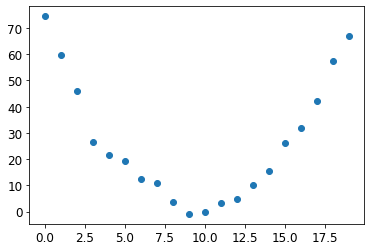

In [54]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

We've added a bit of random noise, since measuring things manually isn't precise. This means it's not that easy to answer the question: what was the roller coaster's speed? Using SGD we can try to find a function that matches our observations. We can't consider every possible function, so let's use a guess that it will be quadratic; i.e., a function of the form `a*(time**2)+(b*time)+c`.

We want to distinguish clearly between the function's input (the time when we are measuring the coaster's speed) and its parameters (the values that define *which* quadratic we're trying). So, let's collect the parameters in one argument and thus separate the input, `t`, and the parameters, `params`, in the function's signature: 

我们添加了一些随机噪声，因为手动测量并不精确。这意味着要回答这个问题并不容易：过山车的速度是多少?使用SGD，我们可以尝试找到一个与我们的观察结果相匹配的函数。我们不能考虑所有可能的函数，所以我们假设它是二次函数;即:`a*(time**2)+(b*time)+c`形式的函数。

我们想要清楚地区分函数的输入(我们测量过山车速度的时间)和它的参数(定义我们尝试*的*二次函数的值)。因此，让我们在一个参数中收集参数，从而在函数签名中将输入`t`和参数`params`分开:

In [55]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In other words, we've restricted the problem of finding the best imaginable function that fits the data, to finding the best *quadratic* function. This greatly simplifies the problem, since every quadratic function is fully defined by the three parameters `a`, `b`, and `c`. Thus, to find the best quadratic function, we only need to find the best values for `a`, `b`, and `c`.

If we can solve this problem for the three parameters of a quadratic function, we'll be able to apply the same approach for other, more complex functions with more parameters—such as a neural net. Let's find the parameters for `f` first, and then we'll come back and do the same thing for the MNIST dataset with a neural net.

We need to define first what we mean by "best." We define this precisely by choosing a *loss function*, which will return a value based on a prediction and a target, where lower values of the function correspond to "better" predictions. It is important for loss functions to return _lower_ values when predictions are more accurate, as the SGD procedure we defined earlier will try to _minimize_ this loss. For continuous data, it's common to use *mean squared error*:

换句话说，我们将寻找适合数据的最佳可想象函数的问题限制为寻找最佳*二次*函数。这大大简化了问题，因为每个二次函数都完全由三个参数`a`, `b`，和`c`定义。因此，要找到最佳二次函数，我们只需要找到`a`, `b`，和`c`的最佳值。

如果我们能解决二次函数的三个参数的问题，我们就能将同样的方法应用于其他更复杂的、参数更多的函数——比如神经网络。让我们先找到`f`的参数，然后我们回来用神经网络对MNIST数据集做同样的事情。

我们首先需要定义“最佳”的含义。我们通过选择一个*损失函数*来精确地定义这一点，该损失函数将根据预测和目标返回一个值，其中函数的较低值对应“更好”的预测。当预测更准确时，损失函数返回较低的值是很重要的，因为我们之前定义的SGD过程将尝试 _最小化_ 这种损失。对于连续数据，通常使用*均方误差*:

In [56]:
def mse(preds, targets): return ((preds-targets)**2).mean()

Now, let's work through our 7 step process.

现在，让我们来完成我们的7个步骤。

#### Step 1: Initialize the parameters

#### 第1步:初始化参数

First, we initialize the parameters to random values, and tell PyTorch that we want to track their gradients, using `requires_grad_`:

首先，我们将参数初始化为随机值，并告诉PyTorch我们想使用`requires_grad_`跟踪它们的梯度:

In [57]:
params = torch.randn(3).requires_grad_()

In [58]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

#### 第2步:计算预测

Next, we calculate the predictions:

接下来，我们计算预测:

In [59]:
preds = f(time, params)

Let's create a little function to see how close our predictions are to our targets, and take a look:

让我们创建一个小函数来看看我们的预测与我们的目标有多接近，然后看看：

In [60]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

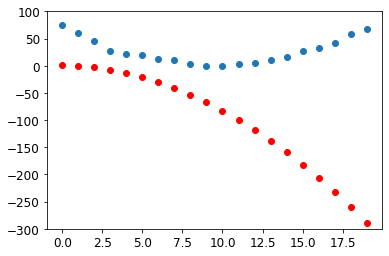

In [61]:
show_preds(preds)

This doesn't look very close—our random parameters suggest that the roller coaster will end up going backwards, since we have negative speeds!

这看起来不是很接近——我们的随机参数表明过山车最终会倒退，因为我们有负速度！

#### Step 3: Calculate the loss

#### 第3步:计算损失

We calculate the loss as follows:

我们计算损失如下：

In [62]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

Our goal is now to improve this. To do that, we'll need to know the gradients.

我们现在的目标是改进这一点。要做到这一点，我们需要知道梯度。

#### Step 4: Calculate the gradients

#### 第4步:计算梯度

The next step is to calculate the gradients. In other words, calculate an approximation of how the parameters need to change:

下一步是计算梯度。换句话说，计算参数需要如何变化的近似值:

In [63]:
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

In [65]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

We can use these gradients to improve our parameters. We'll need to pick a learning rate (we'll discuss how to do that in practice in the next chapter; for now we'll just use 1e-5, or 0.00001):

我们可以使用这些梯度来改进我们的参数。我们需要选择一个学习率(我们将在下一章讨论如何在实践中做到这一点；现在我们只使用1e-5，或0.00001):

In [64]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

#### Step 5: Step the weights. 

#### 第5步:步进权重

Now we need to update the parameters based on the gradients we just calculated:

现在我们需要基于我们刚刚计算的梯度更新参数:

In [66]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

> a: Understanding this bit depends on remembering recent history. To calculate the gradients we call `backward` on the `loss`. But this `loss` was itself calculated by `mse`, which in turn took `preds` as an input, which was calculated using `f` taking as an input `params`, which was the object on which we originally called `requires_grad_`—which is the original call that now allows us to call `backward` on `loss`. This chain of function calls represents the mathematical composition of functions, which enables PyTorch to use calculus's chain rule under the hood to calculate these gradients.

>a:理解这一点取决于记住最近的历史。为了计算梯度，我们在`loss`上调用`backward`。但是这个`loss`本身是由`mse`计算的，它反过来以`preds`作为输入，使用`f`作为输入`params`进行计算，这是我们最初调用`requires_grad_`的对象——这是现在允许我们在`loss`上调用`backward`的原始调用。这个函数调用链表示函数的数学组成，这使得PyTorch能够在底层使用微积分的链式法则来计算这些梯度。

Let's see if the loss has improved:

让我们看看损失是否有所改善:

In [67]:
preds = f(time,params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

And take a look at the plot:

我们来看一下图:

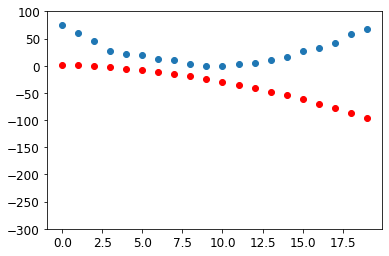

In [68]:
show_preds(preds)

We need to repeat this a few times, so we'll create a function to apply one step:

我们需要重复几次，所以我们将创建一个函数来应用一步:

In [69]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

#### 第6步:重复该过程

Now we iterate. By looping and performing many improvements, we hope to reach a good result:

现在我们进行迭代。通过循环和执行许多改进，我们希望得到一个好的结果:

In [70]:
for i in range(10): apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023193359375
676.9645385742188
676.9537353515625


In [71]:
#hide
params = orig_params.detach().requires_grad_()

The loss is going down, just as we hoped! But looking only at these loss numbers disguises the fact that each iteration represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function. We can see this process visually if, instead of printing out the loss function, we plot the function at every step. Then we can see how the shape is approaching the best possible quadratic function for our data:

损失正在下降，正如我们所希望的那样！但只看这些损失数字掩盖了这样一个事实:即每次迭代都代表一个完全不同的二次函数，正在尝试寻找最好的二次函数。如果不是打印损失函数，而是在每一步绘制函数，我们就可以直观地看到这个过程。然后我们可以看到形状如何接近我们数据的最佳二次函数:

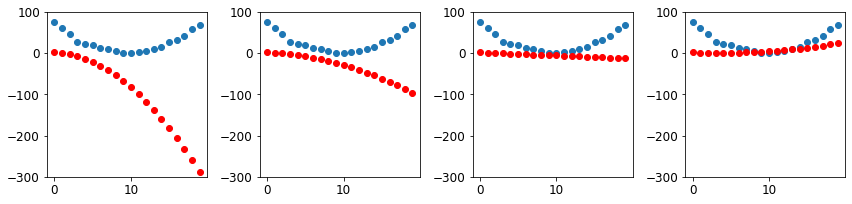

In [72]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

#### 第7步:停止

We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop, as we've discussed.

我们只是随意决定在10轮后停止。在实践中，我们会观察训练和验证损失以及我们的指标来决定何时停止，正如我们所讨论的。

### Summarizing Gradient Descent

### 总结梯度下降

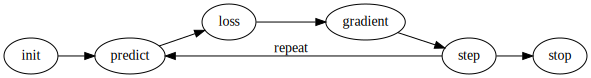

In [ ]:
#hide_input
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

To summarize, at the beginning, the weights of our model can be random (training *from scratch*) or come from a pretrained model (*transfer learning*). In the first case, the output we will get from our inputs won't have anything to do with what we want, and even in the second case, it's very likely the pretrained model won't be very good at the specific task we are targeting. So the model will need to *learn* better weights.

We begin by comparing the outputs the model gives us with our targets (we have labeled data, so we know what result the model should give) using a *loss function*, which returns a number that we want to make as low as possible by improving our weights. To do this, we take a few data items (such as images) from the training set and feed them to our model. We compare the corresponding targets using our loss function, and the score we get tells us how wrong our predictions were. We then change the weights a little bit to make it slightly better.

To find how to change the weights to make the loss a bit better, we use calculus to calculate the *gradients*. (Actually, we let PyTorch do it for us!) Let's consider an analogy. Imagine you are lost in the mountains with your car parked at the lowest point. To find your way back to it, you might wander in a random direction, but that probably wouldn't help much. Since you know your vehicle is at the lowest point, you would be better off going downhill. By always taking a step in the direction of the steepest downward slope, you should eventually arrive at your destination. We use the magnitude of the gradient (i.e., the steepness of the slope) to tell us how big a step to take; specifically, we multiply the gradient by a number we choose called the *learning rate* to decide on the step size. We then *iterate* until we have reached the lowest point, which will be our parking lot, then we can *stop*.

All of that we just saw can be transposed directly to the MNIST dataset, except for the loss function. Let's now see how we can define a good training objective. 

总而言之，在一开始，我们模型的权重可以是随机的(*从头开始*训练)，也可以来自一个预训练模型(*迁移学习*)。在第一种情况下，我们从输入中得到的输出与我们想要的没有任何关系，即使在第二种情况下，预训练的模型也很可能不能很好地完成我们的目标任务。因此，模型需要*学习*更好的权重。

首先，我们使用一个*损失函数*将模型给出的输出与目标(我们已经标记了数据，因此我们知道模型应该给出什么结果)进行比较，它返回一个我们希望通过改进权重使其尽可能低的数字。为此，我们从训练集中获取一些数据项(如图像)，并将它们提供给我们的模型。我们使用我们的损失函数来比较相应的目标，我们得到的分数告诉我们我们的预测有多错误。然后我们稍微改变一下权重，让它稍微好一点。

为了找到如何改变权重使损失更好一点，我们使用微积分来计算*梯度*。(实际上，我们让PyTorch为我们做这件事！)让我们打个比方。想象一下，你在山里迷路了，车停在最低的地方。为了找到回到车的路，你可能会在一个随机的方向徘徊，但这可能没有多大帮助。因为你知道你的车在最低点，你最好下坡。通过始终朝着最陡峭的下坡方向迈出一步，你最终应该到达目的地。我们使用梯度的大小(即坡度的陡度)来告诉我们要迈出多大的步幅；具体来说，我们将梯度乘以我们选择的称为*学习率*的数字来决定步长。然后*迭代*，直到到达最低点，也就是我们的停车场，然后我们就可以*停止*了。

除了损失函数之外，我们刚刚看到的所有内容都可以直接转置到MNIST数据集。现在让我们看看如何定义一个好的训练目标。

## The MNIST Loss Function




## MNIST损失函数

We already have our independent variables `x`—these are the images themselves. We'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). We can do this using `view`, which is a PyTorch method that changes the shape of a tensor without changing its contents. `-1` is a special parameter to `view` that means "make this axis as big as necessary to fit all the data":

我们已经有了自变量`x`——这些是图像本身。我们将把它们全部连接成一个张量，并将它们从矩阵列表(秩为3的张量)变成向量列表(秩为2的张量)。我们可以使用`view`来实现这一点，它是一个PyTorch方法，可以改变张量的形状，而不改变其内容。`-1`是`view`的一个特殊参数，它意味着“使这个轴尽可能大，以适应所有数据”:

In [73]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

We need a label for each image. We'll use `1` for 3s and `0` for 7s:

我们需要为每个图像添加一个标签。我们用`1`表示3s, `0`表示7s:

In [74]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed. Python provides a `zip` function which, when combined with `list`, provides a simple way to get this functionality:

PyTorch中的`Dataset`需要在索引时返回`(x,y)`的元组。Python提供了一个`zip`函数，当与`list`结合使用时，它提供了一种简单的方法来获得此功能：

In [75]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [76]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we need an (initially random) weight for every pixel (this is the *initialize* step in our seven-step process):

现在我们需要每个像素的一个(最初是随机的)权重(这是我们的七步过程中的初始化步骤):

In [77]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [78]:
weights = init_params((28*28,1))

The function `weights*pixels` won't be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its *intercept* is 0). You might remember from high school math that the formula for a line is `y=w*x+b`; we still need the `b`. We'll initialize it to a random number too:

函数`weights*pixels`不够灵活——当像素等于0时，它总是等于0(即，它的*截距*为0)。你可能还记得高中数学中的直线公式是`y=w*x+b`;我们仍然需要`b`。我们也将其初始化为一个随机数:

In [79]:
bias = init_params(1)

In neural networks, the `w` in the equation `y=w*x+b` is called the *weights*, and the `b` is called the *bias*. Together, the weights and bias make up the *parameters*.

在神经网络中，方程`y=w*x+b`中的`w`称为*权重*，`b`称为*偏差*。权重和偏差共同构成了*参数*。

> jargon: Parameters: The _weights_ and _biases_ of a model. The weights are the `w` in the equation `w*x+b`, and the biases are the `b` in that equation.

>术语：参数:模型的 _权重_ 和 _偏差_ 。权重是方程`w*x+b`中的`w`，偏差是方程中的`b`。

We can now calculate a prediction for one image:

我们现在可以计算一个图像的预测：

In [80]:
(train_x[0]*weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

While we could use a Python `for` loop to calculate the prediction for each image, that would be very slow. Because Python loops don't run on the GPU, and because Python is a slow language for loops in general, we need to represent as much of the computation in a model as possible using higher-level functions.

In this case, there's an extremely convenient mathematical operation that calculates `w*x` for every row of a matrix—it's called *matrix multiplication*. <<matmul>> shows what matrix multiplication looks like.

虽然我们可以使用Python `for`循环来计算每个图像的预测，但这会非常慢。因为Python循环不在GPU上运行，而且Python通常对于循环来说是一种慢速语言，所以我们需要使用更高级的函数在模型中表示尽可能多的计算。

在这种情况下，有一个非常方便的数学运算可以计算`w*x`矩阵的每一行——它被称为矩阵乘法。<<matmul>>显示了矩阵乘法的样子。

<img alt="Matrix multiplication" width="400" caption="Matrix multiplication" src="https://github.com/fastai/fastbook/blob/master/images/matmul2.svg?raw=1" id="matmul"/>

This image shows two matrices, `A` and `B`, being multiplied together. Each item of the result, which we'll call `AB`, contains each item of its corresponding row of `A` multiplied by each item of its corresponding column of `B`, added together. For instance, row 1, column 2 (the yellow dot with a red border) is calculated as $a_{1,1} * b_{1,2} + a_{1,2} * b_{2,2}$. If you need a refresher on matrix multiplication, we suggest you take a look at the [Intro to Matrix Multiplication](https://youtu.be/kT4Mp9EdVqs) on *Khan Academy*, since this is the most important mathematical operation in deep learning.

In Python, matrix multiplication is represented with the `@` operator. Let's try it:

这幅图显示了两个矩阵`A`和`B`相乘。结果中的每一项，我们称之为`AB`，包含对应的`A`行中的每一项乘以对应的`B`列中的每一项，相加。例如，第1行第2列(红色边框的黄色圆点)被计算为$a_{1,1} * b_{1,2} + a_{1,2} * b_{2,2}$。如果你需要复习矩阵乘法，我们建议你看看*可汗学院*的[矩阵乘法简介](https://youtu.be/kT4Mp9EdVqs)，因为这是深度学习中最重要的数学运算。

在Python中，矩阵乘法用`@`运算符表示。让我们尝试一下:

In [81]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

The first element is the same as we calculated before, as we'd expect. This equation, `batch@weights + bias`, is one of the two fundamental equations of any neural network (the other one is the *activation function*, which we'll see in a moment).

正如我们所料，第一个元素和我们之前计算的相同。这个方程`batch@weights + bias`是任何神经网络的两个基本方程之一(另一个是*激活函数*，我们稍后会看到)。

Let's check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0.0, so our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

让我们检查一下我们的准确性。要确定输出是代表3还是7，我们只需检查它是否大于0.0，因此可以计算每个项目的准确度(使用广播，所以没有循环!)

In [82]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [83]:
corrects.float().mean().item()

0.4912068545818329

Now let's see what the change in accuracy is for a small change in one of the weights (note that we have to ask PyTorch not to calculate gradients as we do this, which is what `with torch.no_grad()` is doing here):

现在让我们看看对于其中一个权重的微小变化，准确度的变化是什么(请注意，我们必须要求 PyTorch 在我们这样做时不要计算梯度，这就是`with torch.no_grad()`这里所做的):

In [84]:
with torch.no_grad(): weights[0] *= 1.0001

In [85]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4912068545818329

As we've seen, we need gradients in order to improve our model using SGD, and in order to calculate gradients we need some *loss function* that represents how good our model is. That is because the gradients are a measure of how that loss function changes with small tweaks to the weights.

So, we need to choose a loss function. The obvious approach would be to use accuracy, which is our metric, as our loss function as well. In this case, we would calculate our prediction for each image, collect these values to calculate an overall accuracy, and then calculate the gradients of each weight with respect to that overall accuracy.

Unfortunately, we have a significant technical problem here. The gradient of a function is its *slope*, or its steepness, which can be defined as *rise over run*—that is, how much the value of the function goes up or down, divided by how much we changed the input. We can write this in mathematically as: `(y_new - y_old) / (x_new - x_old)`. This gives us a good approximation of the gradient when `x_new` is very similar to `x_old`, meaning that their difference is very small. But accuracy only changes at all when a prediction changes from a 3 to a 7, or vice versa. The problem is that a small change in weights from `x_old` to `x_new` isn't likely to cause any prediction to change, so `(y_new - y_old)` will almost always be 0. In other words, the gradient is 0 almost everywhere.

正如我们所见，我们需要梯度来使用 SGD 改进我们的模型，并且为了计算梯度，我们需要一些*损失函数*来表示我们的模型有多好。这是因为梯度是衡量损失函数如何随着权重的微小调整而变化的度量。

所以，我们需要选择一个损失函数。显而易见的方法是使用准确度，这是我们的指标，也作为我们的损失函数。在这种情况下，我们将计算对每张图像的预测，收集这些值来计算总体准确度，然后计算每个权重相对于总体准确度的梯度。

不幸的是，我们在这里遇到了一个重大的技术问题。一个函数的梯度是它的*斜率*，或者说它的陡度，它可以被定义为*上升超过运行*——即函数值上升或下降的程度除以我们改变输入的程度。我们可以在数学上把它写成:`(y_new - y_old) / (x_new - x_old)`。当`x_new`和`x_old`非常相似时，这为我们提供了一个很好的梯度近似值，这意味着它们的差异非常小。但只有当预测值从3变到7时，准确度才会发生变化，反之亦然。问题是，从`x_old`到`x_new`的权重的微小变化不太可能导致任何预测的变化，因此`(y_new - y_old)`几乎总是0。换句话说，梯度几乎处处为0。

A very small change in the value of a weight will often not actually change the accuracy at all. This means it is not useful to use accuracy as a loss function—if we do, most of the time our gradients will actually be 0, and the model will not be able to learn from that number.

> S: In mathematical terms, accuracy is a function that is constant almost everywhere (except at the threshold, 0.5), so its derivative is nil almost everywhere (and infinity at the threshold). This then gives gradients that are 0 or infinite, which are useless for updating the model.

Instead, we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. So what does a "slightly better prediction" look like, exactly? Well, in this case, it means that if the correct answer is a 3 the score is a little higher, or if the correct answer is a 7 the score is a little lower.

Let's write such a function now. What form does it take?

The loss function receives not the images themselves, but the predictions from the model. Let's make one argument, `prds`, of values between 0 and 1, where each value is the prediction that an image is a 3. It is a vector (i.e., a rank-1 tensor), indexed over the images.

The purpose of the loss function is to measure the difference between predicted values and the true values — that is, the targets (aka labels). Let's make another argument, `trgts`, with values of 0 or 1 which tells whether an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor), indexed over the images.

So, for instance, suppose we had three images which we knew were a 3, a 7, and a 3. And suppose our model predicted with high confidence (`0.9`) that the first was a 3, with slight confidence (`0.4`) that the second was a 7, and with fair confidence (`0.2`), but incorrectly, that the last was a 7. This would mean our loss function would receive these values as its inputs:

权重值的非常小的变化通常不会真正改变准确度。这意味着用准确度作为损失函数是没有用的——如果我们这样做，大多数时候我们的梯度实际上是0，模型将无法从该数字中学习。

>S:用数学术语来说，准确度是一个几乎在任何地方都是常数的函数(除了阈值0.5)，所以它的导数几乎在任何地方都是零(阈值处为无穷大)。这将提供0或无限的梯度，这对于更新模型是无用的。

相反，我们需要一个损失函数，当我们的权重导致稍微更好的预测时，我们就会得到稍微更好的损失。那么，“稍微更好的预测”到底是什么样子的呢?在这种情况下，这意味着如果正确答案是 3 分数会高一点，或者如果正确答案是 7 分数会低一点。

现在让我们编写这样一个函数。它采取什么形式？

损失函数接收的不是图像本身，而是模型的预测结果。让我们做一个参数，`prds`，值在0到1之间，其中每个值都是对图像为3的预测。它是一个向量(即秩1张量)，在图像上进行索引。

损失函数的目的是测量预测值和真实值之间的差异，真实值即目标值(又名标签)。让我们使用另一个参数`trgts`，其值为0或1，表示图像是否为3。它也是一个向量(即另一个秩1张量)，在图像上进行索引。

因此，例如，假设我们有三张已知的图像分别是3,7和3。假设我们的模型以很高的置信度（0.9）预测第一个是3，以轻微的置信度（0.4）预测第二个是7，以相当的置信度（0.2），但错误地预测最后一个是7。这意味着我们的损失函数将接收这些值作为其输入：

In [86]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

Here's a first try at a loss function that measures the distance between `predictions` and `targets`:

下面是测量`predictions`和`targets`之间距离的损失函数的第一次尝试:

In [87]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

We're using a new function, `torch.where(a,b,c)`. This is the same as running the list comprehension `[b[i] if a[i] else c[i] for i in range(len(a))]`, except it works on tensors, at C/CUDA speed. In plain English, this function will measure how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then it will take the mean of all those distances.

> note: Read the Docs: It's important to learn about PyTorch functions like this, because looping over tensors in Python performs at Python speed, not C/CUDA speed! Try running `help(torch.where)` now to read the docs for this function, or, better still, look it up on the PyTorch documentation site.

我们正在使用一个新的函数`torch.where(a,b,c)`这和运行列表推导`[b[i] if a[i] else c[i] for i in range(len(a))]`是一样的，只是它以C/CUDA速度在张量上工作。简单地说，这个函数会测量每个预测值到1的距离(如果应该是1)和到0的距离(如果应该是0)然后取所有这些距离的均值。

>注意:阅读文档:了解这样的PyTorch函数很重要，因为在 Python 中循环张量以 Python 速度执行，而不是C/CUDA速度！现在尝试运行`help(torch.where)`来阅读这个函数的文档，或者更好的做法是在PyTorch网站上查找它。

Let's try it on our `prds` and `trgts`:

让我们在我们的`prds`和`trgts`上试试:

In [88]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

You can see that this function returns a lower number when predictions are more accurate, when accurate predictions are more confident (higher absolute values), and when inaccurate predictions are less confident. In PyTorch, we always assume that a lower value of a loss function is better. Since we need a scalar for the final loss, `mnist_loss` takes the mean of the previous tensor:

您可以看到，当预测更准确时，当准确的预测更有信心时(较高的绝对值)，以及当不准确的预测不那么有信心时，该函数返回一个较低的数字。在PyTorch中，我们总是假设损失函数的值越低越好。因为我们需要一个标量来表示最终的损失，`mnist_loss`取前一个张量的均值:

In [89]:
mnist_loss(prds,trgts)

tensor(0.4333)

For instance, if we change our prediction for the one "false" target from `0.2` to `0.8` the loss will go down, indicating that this is a better prediction:

例如，如果我们将一个“错误”目标的预测从`0.2`更改为`0.8`，损失将会下降，这表明这是一个更好的预测:

In [90]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

One problem with `mnist_loss` as currently defined is that it assumes that predictions are always between 0 and 1. We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that—let's take a look.

`mnist_loss`当前定义的一个问题是，它假设预测总是在0和1之间。那么，我们需要确保情况确实如此！碰巧有一个函数可以做到这一点——让我们来看看。

### Sigmoid

The `sigmoid` function always outputs a number between 0 and 1. It's defined as follows:

`sigmoid`函数总是输出一个介于0和1之间的数字。其定义如下:

In [91]:
def sigmoid(x): return 1/(1+torch.exp(-x))

Pytorch defines an accelerated version for us, so we don’t really need our own. This is an important function in deep learning, since we often want to ensure values are between 0 and 1. This is what it looks like:

Pytorch为我们定义了一个加速版本，所以我们真的不需要自己的。这是深度学习中的一个重要函数，因为我们经常想要确保值在0到1之间。这是它的样子:

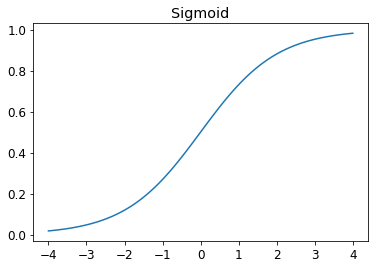

In [92]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

As you can see, it takes any input value, positive or negative, and smooshes it onto an output value between 0 and 1. It's also a smooth curve that only goes up, which makes it easier for SGD to find meaningful gradients. 

Let's update `mnist_loss` to first apply `sigmoid` to the inputs:

如您所见，它接受任何输入值(正的或负的)，并将其平滑到0到1之间的输出值上。这也是一条只上升的平滑曲线，这让SGD更容易找到有意义的梯度。

让我们更新`mnist_loss`，首先将`sigmoid`应用于输入：

In [93]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Now we can be confident our loss function will work, even if the predictions are not between 0 and 1. All that is required is that a higher prediction corresponds to higher confidence an image is a 3.

Having defined a loss function, now is a good moment to recapitulate why we did this. After all, we already had a metric, which was overall accuracy. So why did we define a loss?

The key difference is that the metric is to drive human understanding and the loss is to drive automated learning. To drive automated learning, the loss must be a function that has a meaningful derivative. It can't have big flat sections and large jumps, but instead must be reasonably smooth. This is why we designed a loss function that would respond to small changes in confidence level. This requirement means that sometimes it does not really reflect exactly what we are trying to achieve, but is rather a compromise between our real goal and a function that can be optimized using its gradient. The loss function is calculated for each item in our dataset, and then at the end of an epoch the loss values are all averaged and the overall mean is reported for the epoch.

Metrics, on the other hand, are the numbers that we really care about. These are the values that are printed at the end of each epoch that tell us how our model is really doing. It is important that we learn to focus on these metrics, rather than the loss, when judging the performance of a model.

现在我们可以确信我们的损失函数是可行的，即使预测不在0到1之间。所需要的只是更高的预测对应更高的置信度，图像是3。

定义了损失函数之后，现在是一个很好的时机来总结我们为什么这样做。毕竟，我们已经有了一个指标，即整体准确度。那么我们为什么要定义损失呢?

关键的区别在于，指标是为了推动人类的理解，而损失是为了推动自动化学习。为了推动自动学习，损失必须是一个具有有意义的导数的函数。它不能有大的平坦部分和大的跳跃，而是必须是合理平滑的。这就是为什么我们设计了一个损失函数，它会对置信度的微小变化做出反应。这一要求意味着有时它并不能真正反映我们想要实现的目标，而是我们真正目标和可以使用其梯度进行优化的函数之间的折中。为数据集中的每个项目计算损失函数，然后在一个epoch结束时，对所有损失值取平均值，并报告该epoch的总体平均值。

另一方面，指标是我们真正关心的数字。这些是在每个 epoch 结束时打印的值，它们告诉我们模型的实际情况。在判断模型的性能时，重要的是我们要学会关注这些指标，而不是损失。

### SGD and Mini-Batches

Now that we have a loss function that is suitable for driving SGD, we can consider some of the details involved in the next phase of the learning process, which is to change or update the weights based on the gradients. This is called an *optimization step*.

In order to take an optimization step we need to calculate the loss over one or more data items. How many should we use? We could calculate it for the whole dataset, and take the average, or we could calculate it for a single data item. But neither of these is ideal. Calculating it for the whole dataset would take a very long time. Calculating it for a single item would not use much information, so it would result in a very imprecise and unstable gradient. That is, you'd be going to the trouble of updating the weights, but taking into account only how that would improve the model's performance on that single item.

So instead we take a compromise between the two: we calculate the average loss for a few data items at a time. This is called a *mini-batch*. The number of data items in the mini-batch is called the *batch size*. A larger batch size means that you will get a more accurate and stable estimate of your dataset's gradients from the loss function, but it will take longer, and you will process fewer mini-batches per epoch. Choosing a good batch size is one of the decisions you need to make as a deep learning practitioner to train your model quickly and accurately. We will talk about how to make this choice throughout this book.

Another good reason for using mini-batches rather than calculating the gradient on individual data items is that, in practice, we nearly always do our training on an accelerator such as a GPU. These accelerators only perform well if they have lots of work to do at a time, so it's helpful if we can give them lots of data items to work on. Using mini-batches is one of the best ways to do this. However, if you give them too much data to work on at once, they run out of memory—making GPUs happy is also tricky!

As we saw in our discussion of data augmentation in <<chapter_production>>, we get better generalization if we can vary things during training. One simple and effective thing we can vary is what data items we put in each mini-batch. Rather than simply enumerating our dataset in order for every epoch, instead what we normally do is randomly shuffle it on every epoch, before we create mini-batches. PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you, called `DataLoader`.

A `DataLoader` can take any Python collection and turn it into an iterator over mini-batches, like so:

现在我们有了一个适合驱动SGD的损失函数，我们可以考虑下一阶段学习过程中涉及的一些细节，即根据梯度改变或更新权值。这被称为*优化步骤*。

为了进行优化步骤，我们需要计算一个或多个数据项的损失。我们应该用多少?我们可以对整个数据集进行计算，然后取平均值，也可以对单个数据项进行计算。但这两者都不是理想的。为整个数据集计算它将花费很长时间。为单个项目计算它不会使用太多信息，因此会导致非常不精确和不稳定的梯度。也就是说，您会遇到更新权重的麻烦，但只考虑这将如何提高模型在该单个项目上的性能。

因此，我们在这两者之间进行折中:我们一次计算几个数据项的平均损失。这称为*小批量*。小批量中的数据项数量称为*批量大小*。较大的批大小意味着您将从损失函数中获得对数据集梯度的更准确和稳定的估计，但这将花费更长的时间，并且每个epoch将处理更少的小批。作为深度学习从业者，为了快速准确地训练模型，选择一个好的批量大小是您需要做出的决定之一。我们将在本书中讨论如何做出这个选择。

使用小批量而不是计算单个数据项的梯度的另一个很好的理由是，在实践中，我们几乎总是在GPU等加速器上进行训练。这些加速器只有在一次有很多工作要做的情况下才能表现良好，所以如果我们能给它们提供大量的数据项，这将是很有帮助的。使用小批量是最好的方法之一。然而，如果你给他们太多的数据来一次处理，它们就会耗尽内存——让 GPU 满意也很棘手！

正如我们在<<chapter_production>>中对数据增强的讨论中看到的那样，如果我们可以在训练过程中改变事物，我们就能得到更好的泛化。我们可以改变的一件简单而有效的事情是我们在每个小批量中放入了哪些数据项。我们不是简单地为每个 epoch 枚举我们的数据集，而是在创建小批量之前，我们通常在每个epoch上随机打乱数据集。PyTorch和fastai提供了一个类，它将为你做洗牌和小批量排序，称为`DataLoader`。

`DataLoader`可以接受任何Python集合并将其转换为小批量迭代器，如下所示：

In [94]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

For training a model, we don't just want any Python collection, but a collection containing independent and dependent variables (that is, the inputs and targets of the model). A collection that contains tuples of independent and dependent variables is known in PyTorch as a `Dataset`. Here's an example of an extremely simple `Dataset`:

对于训练模型，我们不只是想要任何Python集合，而是一个包含自变量和因变量（即模型的输入和目标）的集合。包含自变量和因变量元组的集合在PyTorch中称为`Dataset`。这是一个非常简单的`Dataset`示例：

In [95]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass a `Dataset` to a `DataLoader` we will get back mini-batches which are themselves tuples of tensors representing batches of independent and dependent variables:

当我们将`Dataset`传递给`DataLoader`时，我们将返回小批量，它们本身是表示成批的自变量和因变量的张量元组：

In [96]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

We are now ready to write our first training loop for a model using SGD!

现在我们已经准备好使用SGD编写模型的第一个训练循环了!

## Putting It All Together

## 把它们放在一起

It's time to implement the process we saw in <<gradient_descent>>. In code, our process will be implemented something like this for each epoch:

```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

是时候实现我们在<<gradient_descent>>中看到的流程了。在代码中，我们的进程将在每个epoch中实现如下内容：

```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

First, let's re-initialize our parameters:

首先，让我们重新初始化我们的参数:

In [97]:
weights = init_params((28*28,1))
bias = init_params(1)

A `DataLoader` can be created from a `Dataset`:

可以从`Dataset`创建`DataLoader`：

In [98]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

We'll do the same for the validation set:

我们将对验证集执行相同的操作:

In [99]:
valid_dl = DataLoader(valid_dset, batch_size=256)

Let's create a mini-batch of size 4 for testing:

让我们创建一个大小为4的小批量进行测试:

In [100]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [101]:
preds = linear1(batch)
preds

tensor([[-2.1876],
        [-8.3973],
        [ 2.5000],
        [-4.9473]], grad_fn=<AddBackward0>)

In [102]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.7419, grad_fn=<MeanBackward0>)

Now we can calculate the gradients:

现在我们可以计算梯度:

In [103]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0061), tensor([-0.0420]))

Let's put that all in a function:

让我们把这些都放在一个函数中:

In [104]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

and test it:

并测试它：

In [105]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0121), tensor([-0.0840]))

But look what happens if we call it twice:

但是看看如果我们调用它两次会发生什么:

In [106]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0182), tensor([-0.1260]))

The gradients have changed! The reason for this is that `loss.backward` actually *adds* the gradients of `loss` to any gradients that are currently stored. So, we have to set the current gradients to 0 first:

梯度改变了!原因就是这种`loss.backward`实际上是将`loss`的梯度加到当前存储的任何梯度上。因此，我们必须首先将当前的梯度设置为0:

In [107]:
weights.grad.zero_()
bias.grad.zero_();

> note: Inplace Operations: Methods in PyTorch whose names end in an underscore modify their objects _in place_. For instance, `bias.zero_()` sets all elements of the tensor `bias` to 0.

注意：就地操作：PyTorch中名称以下划线结尾的方法就地修改它们的对象。例如，`bias.zero_()`将张量`bias`的所有元素设为0。

Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

我们唯一剩下的步骤是根据梯度和学习率更新权重和偏差。当我们这样做时，我们必须告诉PyTorch不要也采用这一步的梯度——否则当我们尝试在下一批计算导数时，事情会变得非常混乱!如果我们给一个张量的`data`属性赋值，那么PyTorch将不会采取该步骤的梯度。以下是我们一个epoch的基本训练循环:

In [108]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

我们还想通过查看验证集的准确度来检查我们所做的工作。要确定一个输出代表3还是7，我们只需检查它是否大于0。所以我们可以计算每个项目的准确性(使用广播，所以没有循环!)

In [109]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [ True],
        [False]])

That gives us this function to calculate our validation accuracy:

这给了我们这个函数来计算我们的验证准确度：

In [110]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

We can check it works:

我们可以检查它是否有效：

In [111]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)

and then put the batches together:

然后把批次放在一起:

In [112]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [113]:
validate_epoch(linear1)

0.5263

That's our starting point. Let's train for one epoch, and see if the accuracy improves:

这是我们的出发点。让我们训练一个 epoch，看看准确率是否有所提高：

In [114]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6664

Then do a few more:

然后再做几次:

In [115]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8266 0.89 0.9184 0.9277 0.9399 0.9467 0.9506 0.9526 0.956 0.9579 0.9599 0.9609 0.9614 0.9619 0.9633 0.9638 0.9648 0.9658 0.9672 0.9677 

Looking good! We're already about at the same accuracy as our "pixel similarity" approach, and we've created a general-purpose foundation we can build on. Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it's called an *optimizer*.

看起来不错！我们已经与我们的“像素相似度”方法具有相同的准确度，并且我们已经创建了一个可以构建的通用基础。我们的下一步将是创建一个对象来为我们处理SGD步骤。在PyTorch中，它被称为*优化器*。

### Creating an Optimizer



### 创建一个优化器

Because this is such a general foundation, PyTorch provides some useful classes to make it easier to implement. The first thing we can do is replace our `linear1` function with PyTorch's `nn.Linear` module. A *module* is an object of a class that inherits from the PyTorch `nn.Module` class. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

`nn.Linear` does the same thing as our `init_params` and `linear` together. It contains both the *weights* and *biases* in a single class. Here's how we replicate our model from the previous section:

因为这是一个通用的基础，PyTorch提供了一些有用的类，使其更容易实现。我们可以做的第一件事是用PyTorch的`nn.Linear`模块替换我们的`linear1`函数。*模块*是继承自PyTorch的`nn.Module`的类的对象。这个类的对象的行为与标准Python函数相同，因为你可以使用括号调用它们，它们将返回模型的激活。

`nn.Linear`与我们的`init_params`和`linear`一起做同样的事情。它包含了单个类中的*权重*和*偏差*。以下是我们如何复制上一节的模型:

In [116]:
linear_model = nn.Linear(28*28,1)

Every PyTorch module knows what parameters it has that can be trained; they are available through the `parameters` method:

每个PyTorch模块都知道它有哪些可以训练的参数；它们可以通过`parameters`方法获得:

In [117]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to create an optimizer:

我们可以使用这些信息来创建一个优化器:

In [118]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

We can create our optimizer by passing in the model's parameters:

我们可以通过传入模型的参数来创建优化器：

In [119]:
opt = BasicOptim(linear_model.parameters(), lr)

Our training loop can now be simplified to:

我们的训练循环现在可以简化为:

In [120]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

Our validation function doesn't need to change at all:

我们的验证函数根本不需要改变:

In [121]:
validate_epoch(linear_model)

0.461

Let's put our little training loop in a function, to make things simpler:

让我们把我们的小训练循环放在一个函数中，让事情变得更简单:

In [122]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

The results are the same as in the previous section:

结果与上一节相同:

In [123]:
train_model(linear_model, 20)

0.4932 0.7686 0.8555 0.9136 0.9346 0.9482 0.957 0.9634 0.9658 0.9678 0.9697 0.9717 0.9736 0.9746 0.9761 0.977 0.9775 0.9775 0.978 0.9785 

fastai provides the `SGD` class which, by default, does the same thing as our `BasicOptim`:

fastai提供了`SGD`类，默认情况下，它与我们的`BasicOptim`做同样的事情：

In [124]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8179 0.8496 0.9141 0.9346 0.9482 0.957 0.9619 0.9658 0.9673 0.9692 0.9712 0.9741 0.9751 0.9761 0.9775 0.9775 0.978 0.9785 0.979 

fastai also provides `Learner.fit`, which we can use instead of `train_model`. To create a `Learner` we first need to create a `DataLoaders`, by passing in our training and validation `DataLoader`s:

fastai也提供`Learner.fit`，我们可以用它来代替`train_model`。要创建一个`Learner`，我们首先需要通过传递我们的训练和验证`Dataloader`创建一个`Dataloaders`，:

In [125]:
dls = DataLoaders(dl, valid_dl)

To create a `Learner` without using an application (such as `vision_learner`) we need to pass in all the elements that we've created in this chapter: the `DataLoaders`, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

要创建一个不使用应用程序(如`vision_learner`)的`Learner`，我们需要传入本章中创建的所有元素:`Dataloaders`、模型、优化函数(将传递参数)、损失函数，以及可选的任何要打印的指标:

In [126]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

Now we can call `fit`:

现在我们可以调用`fit`:

In [127]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636709,0.503144,0.495584,00:00
1,0.429828,0.248517,0.777233,00:00
2,0.161680,0.155361,0.861629,00:00
3,0.072948,0.097722,0.917566,00:00
4,0.040128,0.073205,0.936212,00:00
5,0.027210,0.059466,0.950442,00:00
6,0.021837,0.050799,0.957802,00:00
7,0.019398,0.044980,0.964181,00:00
8,0.018122,0.040853,0.966143,00:00
9,0.017330,0.037788,0.968106,00:00


As you can see, there's nothing magic about the PyTorch and fastai classes. They are just convenient pre-packaged pieces that make your life a bit easier! (They also provide a lot of extra functionality we'll be using in future chapters.)

With these classes, we can now replace our linear model with a neural network.

正如您所看到的，PyTorch和fastai类并没有什么神奇之处。它们只是方便的预包装件，让你的生活更轻松!(它们还提供了很多额外的功能，我们将在以后的章节中使用。)

有了这些类，我们现在可以用神经网络替换我们的线性模型。

## Adding a Nonlinearity

## 添加非线性

So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

Here is the entire definition of a basic neural network:

到目前为止，我们已经有了一个优化函数参数的通用过程，并且我们已经在一个非常无聊的函数上进行了试验:一个简单的线性分类器。线性分类器的功能非常有限。为了使它变得更复杂(并能够处理更多的任务)，我们需要在两个线性分类器之间添加一些非线性的东西——这就是我们的神经网络。

以下是基本神经网络的完整定义:

In [128]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

That's it! All we have in `simple_net` is two linear classifiers with a `max` function between them.

Here, `w1` and `w2` are weight tensors, and `b1` and `b2` are bias tensors; that is, parameters that are initially randomly initialized, just like we did in the previous section:

就是这样！在`simple_net`中，我们只有两个线性分类器，它们之间有一个`max`函数。

在这里，`w1`和`w2`是权重张量，`b1`和`b2`是偏差张量;也就是说，参数最初是随机初始化的，就像我们在上一节中所做的那样:

In [129]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

The key point about this is that `w1` has 30 output activations (which means that `w2` must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels. You can change that `30` to anything you like, to make the model more or less complex.

That little function `res.max(tensor(0.0))` is called a *rectified linear unit*, also known as *ReLU*. We think we can all agree that *rectified linear unit* sounds pretty fancy and complicated... But actually, there's nothing more to it than `res.max(tensor(0.0))`—in other words, replace every negative number with a zero. This tiny function is also available in PyTorch as `F.relu`:

这里的关键点在于`w1`有30个输出激活(这意味着`w2`必须有30个输入激活，所以它们是匹配的)。这意味着第一层可以构建30个不同的特征，每个特征代表一些不同的像素组合。您可以将`30`更改为任何您喜欢的值，以使模型更复杂或更简单。

这个小函数`res.max(tensor(0.0))`被称为*整流线性单元*，也被称为*ReLU*。我们认为我们都同意*整流线性单元*听起来很花哨和复杂…但实际上，它除了`res.max(tensor(0.0))`没有别的了——换句话说，就是用零替换每个负数。这个小功能在PyTorch中也可用`F.relu`：

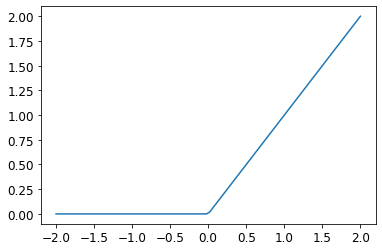

In [130]:
plot_function(F.relu)

> J: There is an enormous amount of jargon in deep learning, including terms like _rectified linear unit_. The vast vast majority of this jargon is no more complicated than can be implemented in a short line of code, as we saw in this example. The reality is that for academics to get their papers published they need to make them sound as impressive and sophisticated as possible. One of the ways that they do that is to introduce jargon. Unfortunately, this has the result that the field ends up becoming far more intimidating and difficult to get into than it should be. You do have to learn the jargon, because otherwise papers and tutorials are not going to mean much to you. But that doesn't mean you have to find the jargon intimidating. Just remember, when you come across a word or phrase that you haven't seen before, it will almost certainly turn out to be referring to a very simple concept.

>J:深度学习中有大量的术语，包括 _整流线性单元_ 这样的术语。正如我们在这个例子中看到的，绝大多数术语并不比一小行代码更复杂。现实是，对于学者来说，要发表他们的论文，他们需要让它们听起来尽可能令人印象深刻和复杂。他们这样做的方法之一是引入术语。不幸的是，这导致了该领域最终变得更加令人生畏和难以进入。你必须学习术语，否则论文和教程对你来说没有多大意义。但这并不意味着你必须对术语感到恐惧。只要记住，当你遇到一个你以前没见过的单词或短语时，它几乎肯定指的是一个非常简单的概念。

The basic idea is that by using more linear layers, we can have our model do more computation, and therefore model more complex functions. But there's no point just putting one linear layer directly after another one, because when we multiply things together and then add them up multiple times, that could be replaced by multiplying different things together and adding them up just once! That is to say, a series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.

But if we put a nonlinear function between them, such as `max`, then this is no longer true. Now each linear layer is actually somewhat decoupled from the other ones, and can do its own useful work. The `max` function is particularly interesting, because it operates as a simple `if` statement.

其基本思想是，通过使用更多的线性层，我们可以让我们的模型进行更多的计算，从而对更复杂的函数进行建模。但是，把一个线性层直接放在另一个线性层之后是没有意义的，因为将事物相乘在一起，然后多次相加时，可以通过将不同的事物相乘并相加来替换它们！也就是说，一行中一系列任意数量的线性层可以替换为具有不同参数集的单个线性层。

但是如果我们在它们之间放一个非线性函数，比如`max`，那么这个就不成立了。现在每一个线性层实际上都是与其他层解耦的，并且可以做自己有用的工作。`max`函数特别有趣，因为它作为一个简单的`if`语句运行。

> S: Mathematically, we say the composition of two linear functions is another linear function. So, we can stack as many linear classifiers as we want on top of each other, and without nonlinear functions between them, it will just be the same as one linear classifier.

>S:数学上，我们说两个线性函数的复合是另一个线性函数。所以，我们可以把任意多的线性分类器堆叠在一起，它们之间没有非线性函数，就和一个线性分类器一样。

Amazingly enough, it can be mathematically proven that this little function can solve any computable problem to an arbitrarily high level of accuracy, if you can find the right parameters for `w1` and `w2` and if you make these matrices big enough. For any arbitrarily wiggly function, we can approximate it as a bunch of lines joined together; to make it closer to the wiggly function, we just have to use shorter lines. This is known as the *universal approximation theorem*. The three lines of code that we have here are known as *layers*. The first and third are known as *linear layers*, and the second line of code is known variously as a *nonlinearity*, or *activation function*.

Just like in the previous section, we can replace this code with something a bit simpler, by taking advantage of PyTorch:

令人惊讶的是，数学上可以证明，这个小函数可以以任意高水平的准确度度解决任何可计算的问题，如果你能找到`w1`和`w2`的正确参数并且使这些矩阵足够大。对于任何任意摆动的函数，我们可以把它近似为一串连接在一起的线;为了让它更接近摆动函数，我们只需要用更短的线。这就是所谓的*普遍逼近定理*。我们这里的三行代码被称为*层*。第一行和第三行被称为*线性层*，第二行代码被称为*非线性*或*激活函数*。

就像上一节一样，我们可以利用PyTorch，用更简单的代码替换这段代码:

In [131]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

`nn.Sequential` creates a module that will call each of the listed layers or functions in turn.

`nn.ReLU` is a PyTorch module that does exactly the same thing as the `F.relu` function. Most functions that can appear in a model also have identical forms that are modules. Generally, it's just a case of replacing `F` with `nn` and changing the capitalization. When using `nn.Sequential`, PyTorch requires us to use the module version. Since modules are classes, we have to instantiate them, which is why you see `nn.ReLU()` in this example. 

Because `nn.Sequential` is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. Let's try it out! As this is a deeper model, we'll use a lower learning rate and a few more epochs.

`nn.Sequential`创建一个模块，该模块将依次调用列出的每一层或函数。

`nn.ReLU`是一个PyTorch模块，它做的事情与`F.relu`函数完全相同。模型中可以出现的大多数函数也具有相同的形式，即模块。通常，就是用`nn`替换`F`并更改大写的情况。当使用`nn.Sequential`，PyTorch要求我们使用模块版本。由于模块是类，我们必须实例化它们，这就是为什么你会在本例中看到`nn.ReLU()`。

因为`nn.Sequential`是一个模块，我们可以获取它的参数，这将返回它所包含的所有模块的所有参数的列表。让我们试试看！由于这是一个更深的模型，我们将使用较低的学习率和更多的epoch。

In [132]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [133]:
#hide_output
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.333021,0.396112,0.512267,00:00
1,0.152461,0.235238,0.797350,00:00
2,0.083573,0.117471,0.911678,00:00
3,0.054309,0.078720,0.940628,00:00
4,0.040829,0.061228,0.956330,00:00
5,0.034006,0.051490,0.963690,00:00
6,0.030123,0.045381,0.966634,00:00
7,0.027619,0.041218,0.968106,00:00
8,0.025825,0.038200,0.969087,00:00
9,0.024441,0.035901,0.969578,00:00


We're not showing the 40 lines of output here to save room; the training process is recorded in `learn.recorder`, with the table of output stored in the `values` attribute, so we can plot the accuracy over training as:

为了节省空间，我们没有在这里显示40行输出；训练过程记录在`learn.recorder`，输出表存储在`values`属性中，因此我们可以将训练的准确度绘制为:

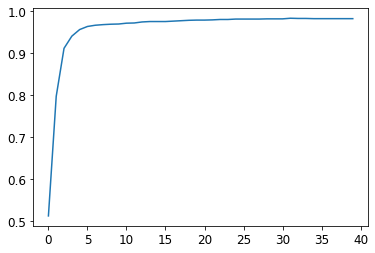

In [134]:
plt.plot(L(learn.recorder.values).itemgot(2));

And we can view the final accuracy:

我们可以看到最终的准确度:

In [135]:
learn.recorder.values[-1][2]

0.98233562707901

At this point we have something that is rather magical:

1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
1. A way to find the best set of parameters for any function (stochastic gradient descent)

This is why deep learning can do things which seem rather magical, such fantastic things. Believing that this combination of simple techniques can really solve any problem is one of the biggest steps that we find many students have to take. It seems too good to be true—surely things should be more difficult and complicated than this? Our recommendation: try it out! We just tried it on the MNIST dataset and you have seen the results. And since we are doing everything from scratch ourselves (except for calculating the gradients) you know that there is no special magic hiding behind the scenes.

在这一点上，我们有一些相当神奇的东西:

1. 给定正确的参数集的情况下，可以以任何精度（神经网络）解决任何问题的函数
1. 一种为任意函数找到最佳参数集的方法(随机梯度下降)

这就是为什么深度学习可以做一些看起来相当神奇的事情，如此奇妙的事情。相信这种简单技术的组合可以真正解决任何问题，这是我们发现许多学生必须采取的最大步骤之一。这似乎好得令人难以置信——事情肯定比这更困难和复杂吗？我们的建议是:试试看！我们刚刚在MNIST数据集上尝试了一下，你已经看到了结果。因为我们自己从头开始做所有的事情(除了计算梯度)，所以你知道并没有什么特殊的魔法隐藏在幕后。

### Going Deeper

### 越来越深

There is no need to stop at just two linear layers. We can add as many as we want, as long as we add a nonlinearity between each pair of linear layers. As you will learn, however, the deeper the model gets, the harder it is to optimize the parameters in practice. Later in this book you will learn about some simple but brilliantly effective techniques for training deeper models.

We already know that a single nonlinearity with two linear layers is enough to approximate any function. So why would we use deeper models? The reason is performance. With a deeper model (that is, one with more layers) we do not need to use as many parameters; it turns out that we can use smaller matrices with more layers, and get better results than we would get with larger matrices, and few layers.

That means that we can train the model more quickly, and it will take up less memory. In the 1990s researchers were so focused on the universal approximation theorem that very few were experimenting with more than one nonlinearity. This theoretical but not practical foundation held back the field for years. Some researchers, however, did experiment with deep models, and eventually were able to show that these models could perform much better in practice. Eventually, theoretical results were developed which showed why this happens. Today, it is extremely unusual to find anybody using a neural network with just one nonlinearity.

Here is what happens when we train an 18-layer model using the same approach we saw in <<chapter_intro>>:

没有必要只停留在两个线性层。我们想加多少就加多少，只要我们在每对线性层之间加一个非线性。然而，正如您将了解到的那样，模型越深入，在实践中优化参数就越困难。在本书的后面部分，您将了解一些用于训练更深层次模型的简单但非常有效的技术。

我们已经知道具有两个线性层的单个非线性足以逼近任何函数。那么我们为什么要使用更深层次的模型呢?原因在于性能。对于更深层次的模型(也就是说，有更多层的模型)，我们不需要使用太多的参数；事实证明，我们可以使用具有更多层的更小的矩阵，并且获得比具有更大矩阵和更少层的更好的结果。

这意味着我们可以更快地训练模型，并且占用更少的内存。在20世纪90年代，研究人员如此专注于普遍逼近定理，以至于很少有人对不止一个非线性进行实验。这种理论而非实践的基础多年来一直阻碍着该领域的发展。然而，一些研究人员确实对深度模型进行了实验，最终能够证明这些模型在实践中可以表现得更好。最终，理论结果显示了为什么会发生这种情况。今天，很少有人使用只有一个非线性的神经网络。

以下是我们使用<<chapter_intro>>中看到的相同方法训练18层模型时发生的情况:

In [136]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,accuracy,time
0,0.110912,0.023535,0.995093,12:45


Nearly 100% accuracy! That's a big difference compared to our simple neural net. But as you'll learn in the remainder of this book, there are just a few little tricks you need to use to get such great results from scratch yourself. You already know the key foundational pieces. (Of course, even once you know all the tricks, you'll nearly always want to work with the pre-built classes provided by PyTorch and fastai, because they save you having to think about all the little details yourself.)

近100%的准确性!与我们简单的神经网络相比，这是一个很大的不同。但是，正如你将在本书的其余部分学到的那样，你只需要使用一些小技巧，就可以自己从头开始获得如此出色的结果。你已经知道了关键的基础部分。(当然，即使你知道了所有的技巧，你几乎总是想使用PyTorch和fastai提供的预构建类，因为它们省去了你自己考虑所有小细节的麻烦。)

## Jargon Recap

## 术语回顾

Congratulations: you now know how to create and train a deep neural network from scratch! We've gone through quite a few steps to get to this point, but you might be surprised at how simple it really is.

Now that we are at this point, it is a good opportunity to define, and review, some jargon and key concepts.

A neural network contains a lot of numbers, but they are only of two types: numbers that are calculated, and the parameters that these numbers are calculated from. This gives us the two most important pieces of jargon to learn:

- Activations:: Numbers that are calculated (both by linear and nonlinear layers)
- Parameters:: Numbers that are randomly initialized, and optimized (that is, the numbers that define the model)

We will often talk in this book about activations and parameters. Remember that they have very specific meanings. They are numbers. They are not abstract concepts, but they are actual specific numbers that are in your model. Part of becoming a good deep learning practitioner is getting used to the idea of actually looking at your activations and parameters, and plotting them and testing whether they are behaving correctly.

Our activations and parameters are all contained in *tensors*. These are simply regularly shaped arrays—for example, a matrix. Matrices have rows and columns; we call these the *axes* or *dimensions*. The number of dimensions of a tensor is its *rank*. There are some special tensors:

- Rank zero: scalar
- Rank one: vector
- Rank two: matrix

A neural network contains a number of layers. Each layer is either *linear* or *nonlinear*. We generally alternate between these two kinds of layers in a neural network. Sometimes people refer to both a linear layer and its subsequent nonlinearity together as a single layer. Yes, this is confusing. Sometimes a nonlinearity is referred to as an *activation function*.

<<dljargon1>> summarizes the key concepts related to SGD.

```asciidoc
[[dljargon1]]
.Deep learning vocabulary
[options="header"]
|=====
| Term | Meaning
|ReLU | Function that returns 0 for negative numbers and doesn't change positive numbers.
|Mini-batch | A small group of inputs and labels gathered together in two arrays. A gradient descent step is updated on this batch (rather than a whole epoch).
|Forward pass | Applying the model to some input and computing the predictions.
|Loss | A value that represents how well (or badly) our model is doing.
|Gradient | The derivative of the loss with respect to some parameter of the model.
|Backward pass | Computing the gradients of the loss with respect to all model parameters.
|Gradient descent | Taking a step in the directions opposite to the gradients to make the model parameters a little bit better.
|Learning rate | The size of the step we take when applying SGD to update the parameters of the model.
|=====
```

恭喜:您现在知道如何从头开始创建和训练深度神经网络了！我们已经完成了相当多的步骤才达到这一点，但您可能会惊讶于它实际上是多么简单。

既然我们已经到了这一步，现在是定义和回顾一些术语和关键概念的好机会。

神经网络包含很多数字，但它们只有两种类型:计算的数字，以及计算这些数字的参数。这给了我们两个最重要的术语需要学习:

- Activations::计算的数字(通过线性和非线性层)
- Parameters::随机初始化和优化的数字(即定义模型的数字)

我们将经常在本书中讨论激活和参数。记住，它们有非常具体的含义。他们是数字。它们不是抽象的概念，而是模型中实际存在的具体数字。成为一名优秀的深度学习实践者的一部分是习惯于实际查看您的激活和参数，绘制它们并测试它们是否行为正确。

我们的激活和参数都包含在*张量*中。这些只是规则形状的数组——例如，矩阵。矩阵有行和列;我们称这些为*轴*或*维度*。一个张量的维数就是它的*秩*。有一些特殊的张量:

0级:标量
1级:向量
2级:矩阵

神经网络包含许多层。每一层都是*线性*或*非线性*的。在神经网络中，我们通常交替使用这两种层。有时人们把线性层和随后的非线性层一起称为单层。是的，这令人困惑。有时非线性被称为*激活函数*。

<<dljargon1>>总结了SGD相关的关键概念。

```asciidoc
[[dljargon1]]
.Deep learning vocabulary
[options="header"]
|=====
| Term | Meaning
|ReLU | Function that returns 0 for negative numbers and doesn't change positive numbers.
|Mini-batch | A small group of inputs and labels gathered together in two arrays. A gradient descent step is updated on this batch (rather than a whole epoch).
|Forward pass | Applying the model to some input and computing the predictions.
|Loss | A value that represents how well (or badly) our model is doing.
|Gradient | The derivative of the loss with respect to some parameter of the model.
|Backward pass | Computing the gradients of the loss with respect to all model parameters.
|Gradient descent | Taking a step in the directions opposite to the gradients to make the model parameters a little bit better.
|Learning rate | The size of the step we take when applying SGD to update the parameters of the model.
|=====
```

> note: _Choose Your Own Adventure_ Reminder: Did you choose to skip over chapters 2 & 3, in your excitement to peek under the hood? Well, here's your reminder to head back to chapter 2 now, because you'll be needing to know that stuff very soon!

>注意: _选择你自己的冒险_提醒:你是否选择跳过第2章和第3章，兴奋地从底层偷看？这里提醒您现在回到第 2 章，因为您很快就会需要了解这些内容！

## Questionnaire

## 问卷调查

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

1. 灰度图像在计算机上是如何表示的?彩色图像怎么样?
1. `MNIST_SAMPLE`数据集中的文件和文件夹结构如何?为什么?
1. 解释分类数字的“像素相似性”方法是如何工作的。
1. 什么是列表理解?现在创建一个从列表中选择奇数并将它们加倍的列表。
1. 什么是“3阶张量”?
1. 张量秩和形状的区别是什么?如何从形状中得到秩?
1. 什么是RMSE和L1范数?
1. 如何一次对数千个数字进行计算，比Python循环快数千倍?
1. 创建一个包含从 1 到 9 的数字的 3×3 张量或数组。将其翻倍。选择右下角的四个数字。
1. 什么是广播？
1. 指标通常是使用训练集还是验证集来计算的?为什么?
1. SGD是什么?
1. 为什么SGD使用小批量?
1. SGD中机器学习的七个步骤是什么？
1. 如何初始化模型中的权重?
1. 什么是“损失”?
1. 为什么我们不能总是使用高学习率呢?
1. 什么是“梯度”?
1. 你需要知道如何自己计算梯度吗?
1. 为什么我们不能用准确度作为损失函数呢?
1. 绘制sigmoid 函数。它的形状有什么特别之处?
1. 损失函数和指标之间的区别是什么?
1. 使用学习率计算新权重的函数是什么?
1. `DataLoader`类做什么?
1. 编写伪代码，展示SGD在每个epoch中所采取的基本步骤。
1. 创建一个函数，如果传入两个参数`[1,2,3,4]`和`'abcd'`，将返回`[(1，'a')， (2， 'b')， (3， 'c')， (4， 'd')]`。该输出数据结构有什么特别之处?
1. `view`在PyTorch中做什么?
1. 神经网络中的“偏差”参数是什么?我们为什么需要它们?
1. `@`运算符在Python中做什么?
1. `backward`方法的作用是什么?
1. 为什么我们必须将梯度归零?
1. 我们有什么信息要传递给`Learner`?
1. 显示训练循环的基本步骤的 Python 或伪代码。
1. 什么是“ReLU”?为从`-2`到`+2`的值绘制它的图。
1. 什么是“激活函数”?
1. `F.relu`和`nn.ReLU`有什么区别?
1. 普遍逼近定理表明，只要使用一个非线性，任何函数都可以根据需要尽可能地逼近。那么为什么我们通常会使用更多呢？

### Further Research

### 进一步的研究

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.

1. 基于本章所示的训练循环，从头开始创建你自己的`Learner`实现。
2. 使用完整的MNIST数据集（即所有数字，而不仅仅是3和7）完成本章中的所有步骤。这是一个重要的项目，将花费你相当多的时间来完成!你需要自己做一些研究，找出如何克服途中遇到的一些障碍。